# Heart Disease (HD) Dataset

#### | VARIABLE NAMES |
- X_train_original, X_val_original, X_test_original -> these variables contain the original data and have not undergone Standard Scaling or OHE
- X_train, X_val, X_test -> all three of these have undergo Standard Scaling and OHE
- y_train, y_val, y_test


**Features:**
- Age - Numeric (discrete) - int
- Sex - Categorical (nominal) - object
- ChestPainType - Categorical (nominal) - object
- RestingBP - Numeric (discrete) - int
- Cholesterol - Numeric (discrete) - int
- FastingBS - Categorical (nominal) - given as int
    - 0 usually indicates normal fasting blood sugar (≤ 120 mg/dL).
    - 1 usually indicates elevated fasting blood sugar (> 120 mg/dL).
- RestingECG - Categorical (nominal) - object
- MaxHR - Numeric (discrete) - int
- ExerciseAngina - Categorical (nominal) - object
- Oldpeak - Numeric (continuous) - int
- ST_Slope - Categorical (nominal) - object

**Target Variable:**
- HeartDisease - Numeric (discrete) - int


In [1]:
!pip install numpy
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install imblearn
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.8 MB/s eta 0:00:00a 0:00:01


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import shap

from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import tree

from sklearn.metrics import accuracy_score, brier_score_loss
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, matthews_corrcoef, log_loss, brier_score_loss

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import CalibrationDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest, f_classif


In [3]:
df_raw = pd.read_csv("heart.csv")
display(df_raw.head(10))

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   
5   39   M           NAP        120          339          0     Normal    170   
6   45   F           ATA        130          237          0     Normal    170   
7   54   M           ATA        110          208          0     Normal    142   
8   37   M           ASY        140          207          0     Normal    130   
9   48   F           ATA        120          284          0     Normal    120   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
5              N      0.0       Up             0  
6              N      0.0       Up             0  
7              N      0.0       Up             0  
8              Y      1.5     Flat             1  
9              N      0.0       Up             0

## ---CHECK FOR MISSING VALUES---

In [4]:
df_heart = df_raw.copy()

df_heart.info() # examine the data types and look for missing values

print(df_heart.isna().sum())
print(f"Total missing: {df_heart.isna().sum().sum()}")
print(f"Shape before dropping missing values: {df_heart.shape}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST

#### *Comments*
- No missing values

## ---SUMMARY STATISTICS---

In [5]:
df_heart.describe() # examine the summary statistics

Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000

In [6]:
# print the number of unique values for each column

for col in df_heart.columns:
    print(f"{col}: {df_heart[col].nunique()} unique values")

Age: 50 unique values
Sex: 2 unique values
ChestPainType: 4 unique values
RestingBP: 67 unique values
Cholesterol: 222 unique values
FastingBS: 2 unique values
RestingECG: 3 unique values
MaxHR: 119 unique values
ExerciseAngina: 2 unique values
Oldpeak: 53 unique values
ST_Slope: 3 unique values
HeartDisease: 2 unique values


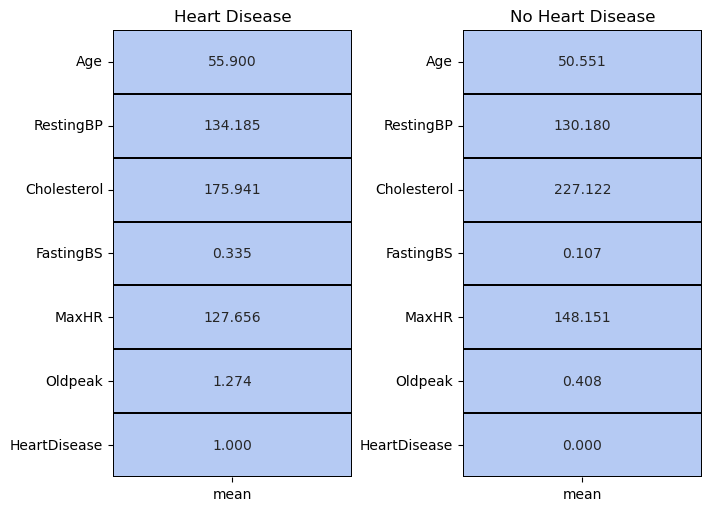

In [7]:
yes = df_heart[df_heart['HeartDisease'] == 1].describe().T
no = df_heart[df_heart['HeartDisease'] == 0].describe().T
custom_colors = ['#B5CAF3']

# build the two panels side‑by‑side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 5), 
                         constrained_layout=True)         

sns.heatmap(no[['mean']],  annot=True, ax=axes[1],
            cmap=custom_colors, linewidths=.2, linecolor='black',
            cbar=False, fmt='.3f')
axes[1].set_title('No Heart Disease')

sns.heatmap(yes[['mean']], annot=True, ax=axes[0],
            cmap=custom_colors, linewidths=.2, linecolor='black',
            cbar=False, fmt='.3f')
axes[0].set_title('Heart Disease')



plt.show()


#### *Comments*
- Age: HD cohort older on average (≈ 55.9 y vs 50.6 y).
- Resting BP: Slightly higher in HD group (≈ 134 mmHg vs 130 mmHg).
- Cholesterol: Unexpectedly lower in HD group (≈ 176 mg/dL vs 227 mg/dL), could reflect treatment bias.
- FastingBS: Substantially higher average in HD group (0.335 vs 0.107), suggesting that elevated blood glucose is assocated with greater risk of HD. 
- Max HR: HD patients achieve lower exercise peak (≈ 128 bpm vs 148 bpm).
- Oldpeak (ST‑depression): Markedly higher in HD group (≈ 1.27 mm vs 0.41 mm), can reflect ischemia.

Patterns: Older age, higher resting BP, higher fasting BSgreater ST‑segment depression, and blunted peak HR are associated with heart‑disease cases in this dataset, whereas increased cholesterol shows an inverse relationship with heart-disease here.

## ---VIEW VARIABLE DISTRIBUTIONS---

In [8]:
# convert FastingBS to categorical (since it has only two values)
df_heart['FastingBS'] = df_heart['FastingBS'].astype('object')

# select categorical features
categorical_features = df_heart.select_dtypes(include='object').columns.tolist() 
print("Categorical Features: ", categorical_features)

# target variable
target_variables = ['HeartDisease']

Categorical Features:  ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


### (i) Overall distribution of target variable

/tmp/ipykernel_1358/2148320221.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_heart, x=target_variables[0], ax=ax, palette='coolwarm')


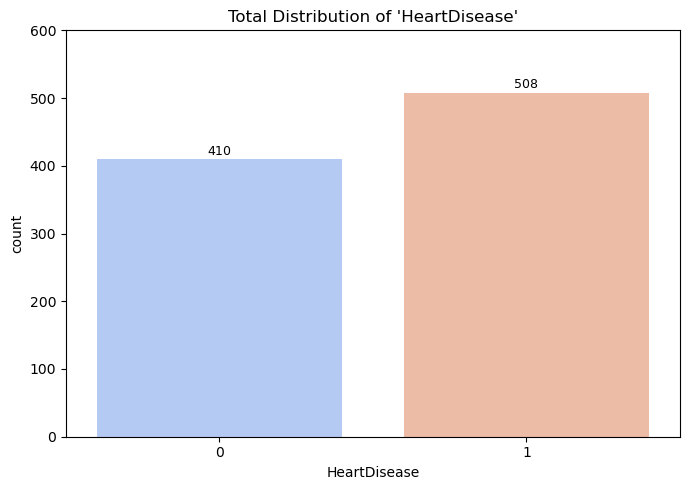

In [9]:
# overall distribution of the target variable (heart disease)
fig, ax = plt.subplots(figsize=(7, 5))

sns.countplot(data=df_heart, x=target_variables[0], ax=ax, palette='coolwarm')
ax.set_ylim(0, 600)
ax.set_title(f"Total Distribution of '{target_variables[0]}'")

for bar in ax.patches:                       
    height = bar.get_height()                
    ax.text(bar.get_x() + bar.get_width()/2, 
            height + 2,                      
            f'{int(height)}',                
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

#### *Comments*
- Heart disease samples are slightly more common than healthy samples in this dataset.

### (ii) Overall distribution of features

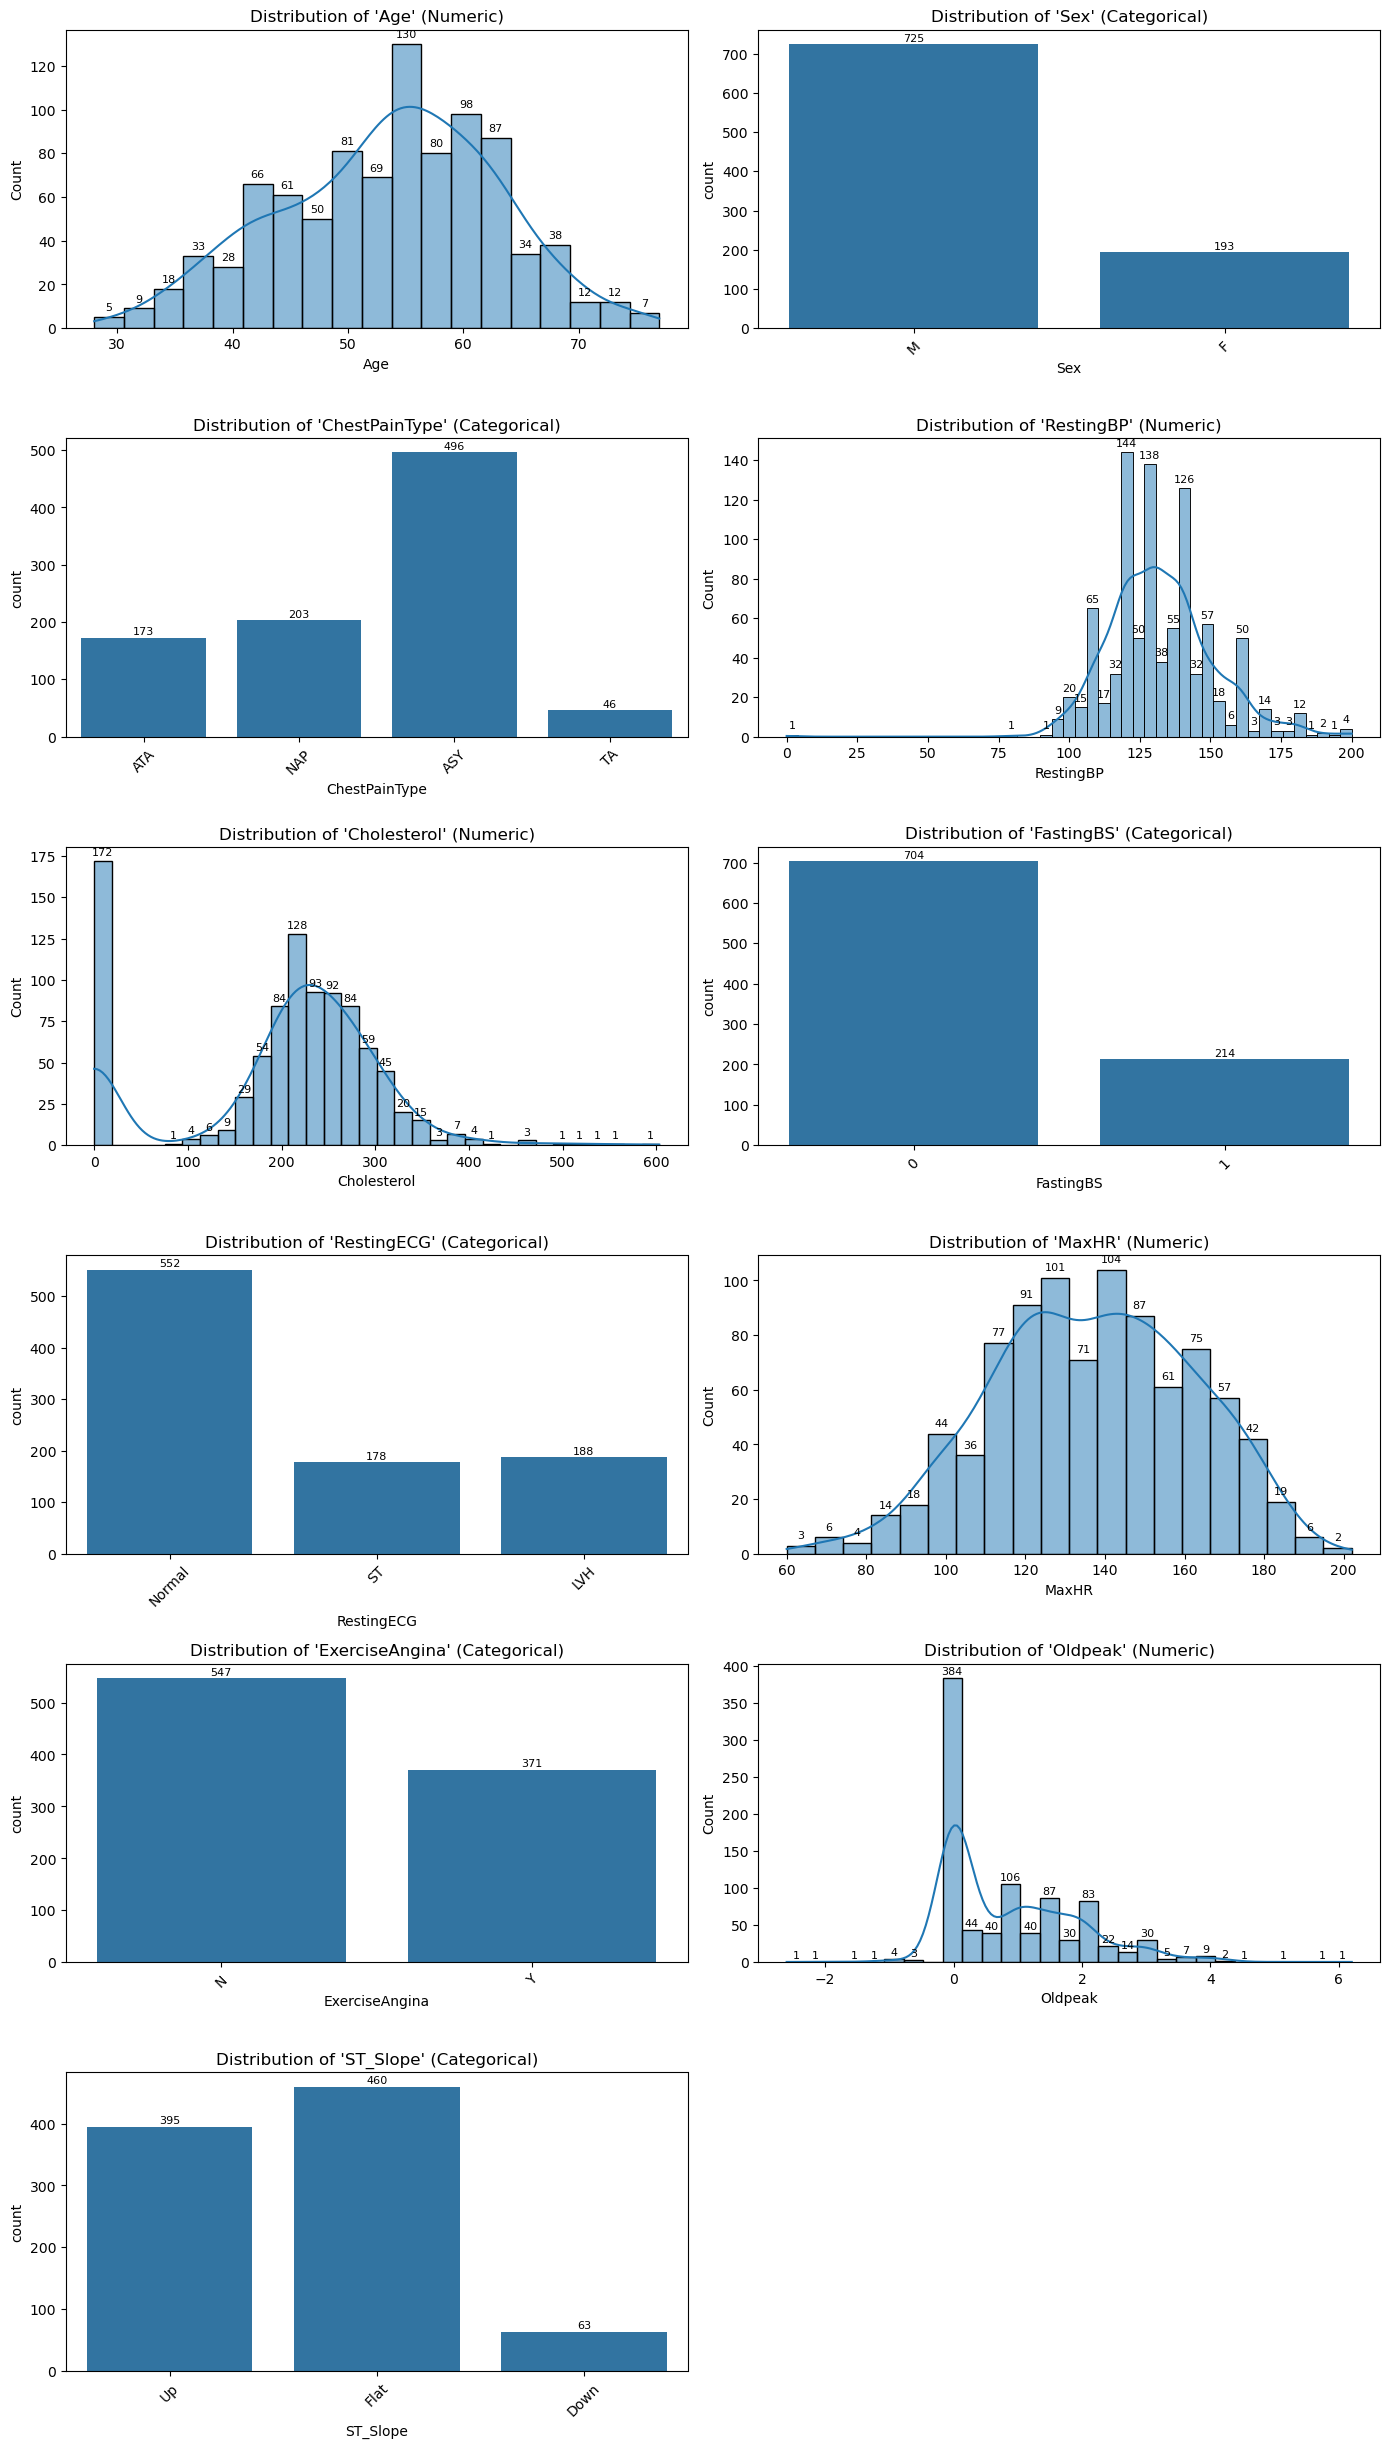

In [10]:
fig, axes = plt.subplots(7, 2, figsize=(14, 28))
axes = axes.flatten()

filtered_columns = [c for c in df_heart.columns if c not in target_variables]

for i, col in enumerate(filtered_columns):
    ax = axes[i]

    if df_heart[col].dtype == 'object': # categorical features  
        sns.countplot(data=df_heart, x=col, ax=ax)
        ax.set_title(f"Distribution of '{col}' (Categorical)")
        plt.setp(ax.get_xticklabels(), rotation=45)

        # add count labels 
        for bar in ax.patches:
            h = bar.get_height()
            if h:
                ax.text(bar.get_x() + bar.get_width() / 2,
                        h + 2,
                        f'{int(h)}',
                        ha='center', va='bottom', fontsize=8)

    else: # numeric features                                        
        sns.histplot(data=df_heart, x=col, kde=True, ax=ax)
        ax.set_title(f"Distribution of '{col}' (Numeric)")

        for bar in ax.patches:
            h = bar.get_height()
            if h:
                ax.text(bar.get_x() + bar.get_width() / 2,
                        h + 2,
                        f'{int(h)}',
                        ha='center', va='bottom', fontsize=8)

# remove any unused panels
for j in range(len(filtered_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## ---FEATURES VS TARGET---

### (i) Categorical Features vs Target Variable (HeartDisease)

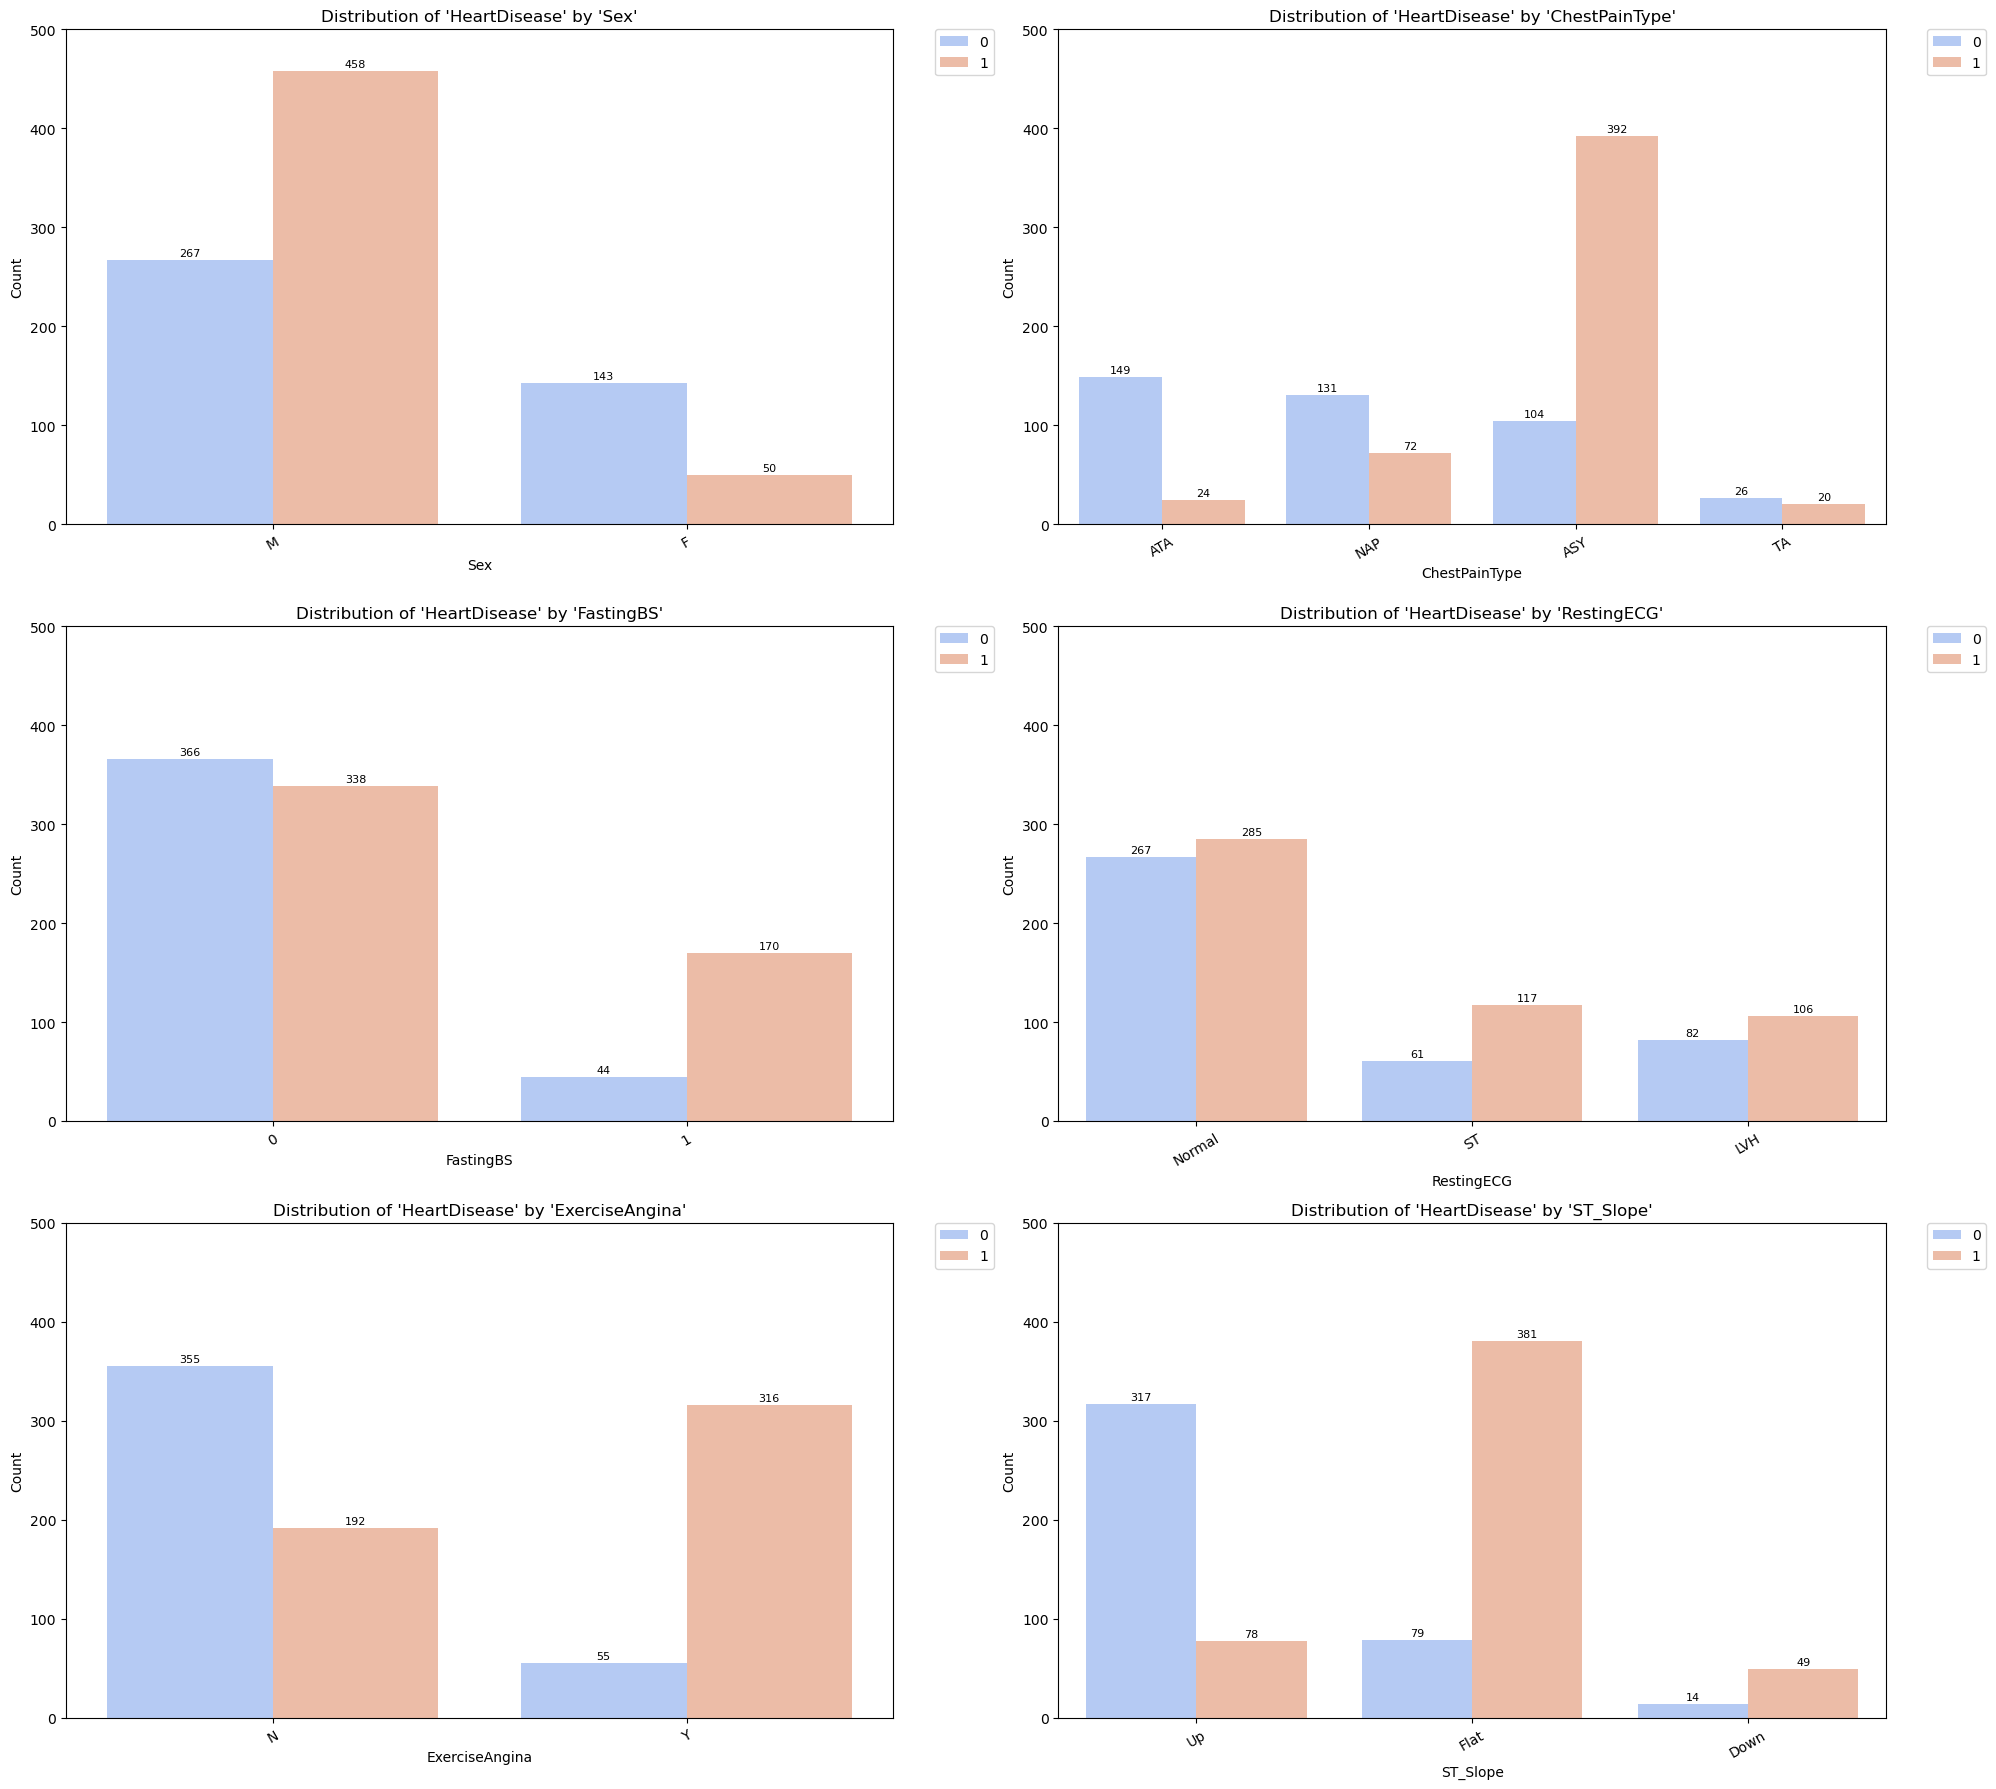

In [11]:
# dynamically create a grid of subplots
n_plots = len(categorical_features) * len(target_variables)
n_cols   = 2
n_rows   = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(n_cols*10, n_rows*6))
axes = axes.flatten()

idx = 0
for target in target_variables:
    for feature in categorical_features:
        ax = axes[idx]    

        sns.countplot(data=df_heart,
                      x=feature,
                      hue=target,
                      palette="coolwarm",
                      ax=ax)

        ax.set_title(f"Distribution of '{target}' by '{feature}'")
        ax.set_xlabel(feature)
        ax.set_ylabel("Count")
        ax.set_ylim(0, 500)
        ax.legend(loc='upper left',
                  bbox_to_anchor=(1.05, 1),
                  borderaxespad=0.)
        plt.setp(ax.get_xticklabels(), rotation=30)

        # count labels
        for bar in ax.patches:
            h = bar.get_height()
            if h: 
                ax.text(bar.get_x() + bar.get_width() / 2,
                        h + 2,
                        f'{int(h)}',
                        ha='center', va='bottom', fontsize=8)

        idx += 1   

# hide any unused panels
for ax in axes[idx:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


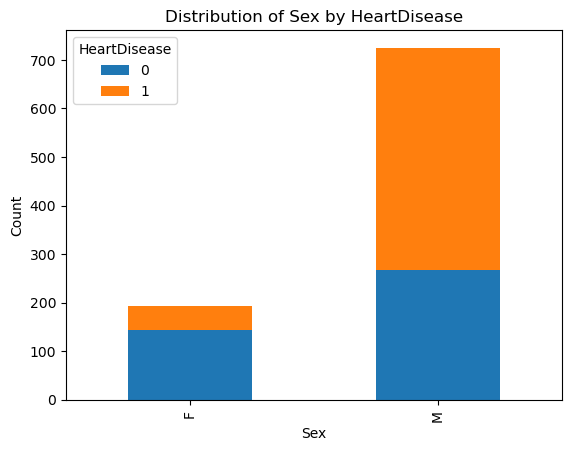

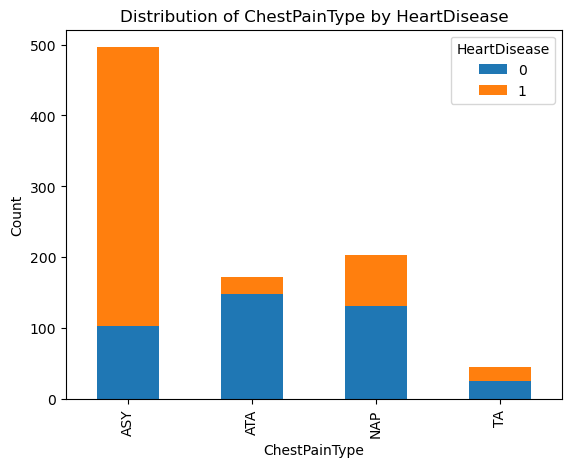

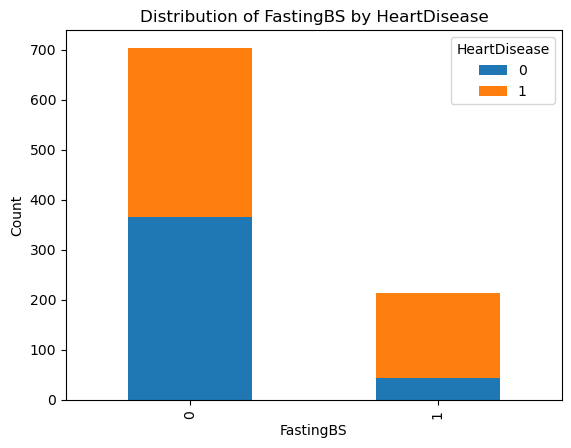

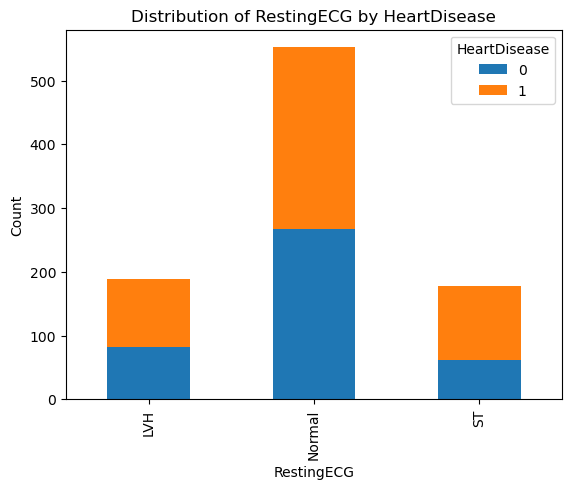

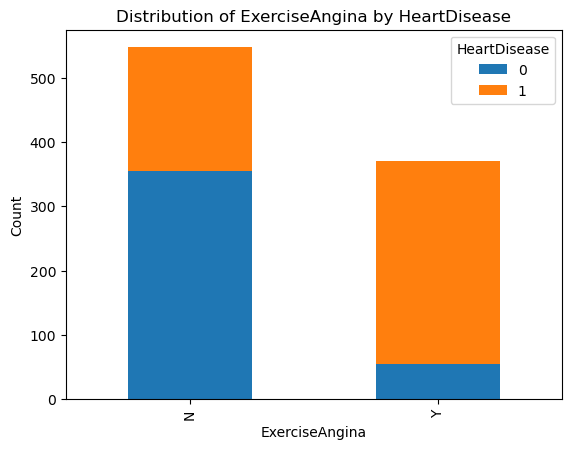

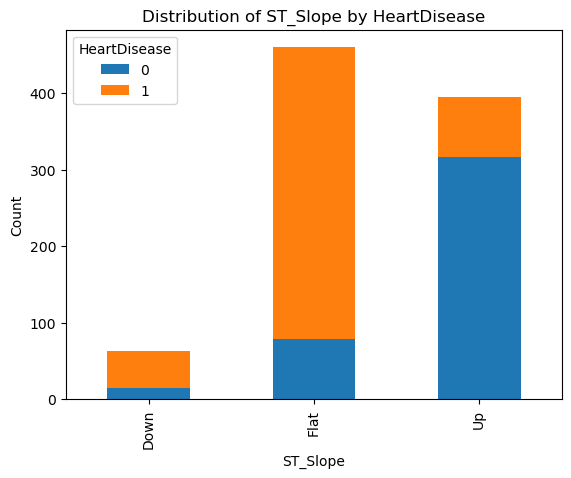

In [12]:
for col in categorical_features:
    pd.crosstab(df_heart[col], df_heart['HeartDisease']).plot(kind='bar', stacked=True)
    plt.title(f"Distribution of {col} by HeartDisease")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend(title='HeartDisease')
    plt.show()

#### *Comments*
- Males have a higher rate of heart disease compared to females.
- ChestPainType of 'ASY' appears associated with higher rate of heart disease.
- FastingBS of 1 appears associated with higher rate of heart disease.
- RestingECG of 'ST' appears associated with higher rate of heart disease.
- ExerciseAngina is associated with higher rate of heart disease.
- Flat ST_Slope is associated with higher rate of heart disease.

### (ii) Numerical Features vs Target Variable (HeartDisease)

In [13]:
# select numerical features
numeric_features = df_heart.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('HeartDisease')

#### *a. Box Plots*

/tmp/ipykernel_1358/3214213952.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1358/3214213952.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1358/3214213952.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1358/3214213952.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1358/3214213952.py:10: FutureWarning: 

P

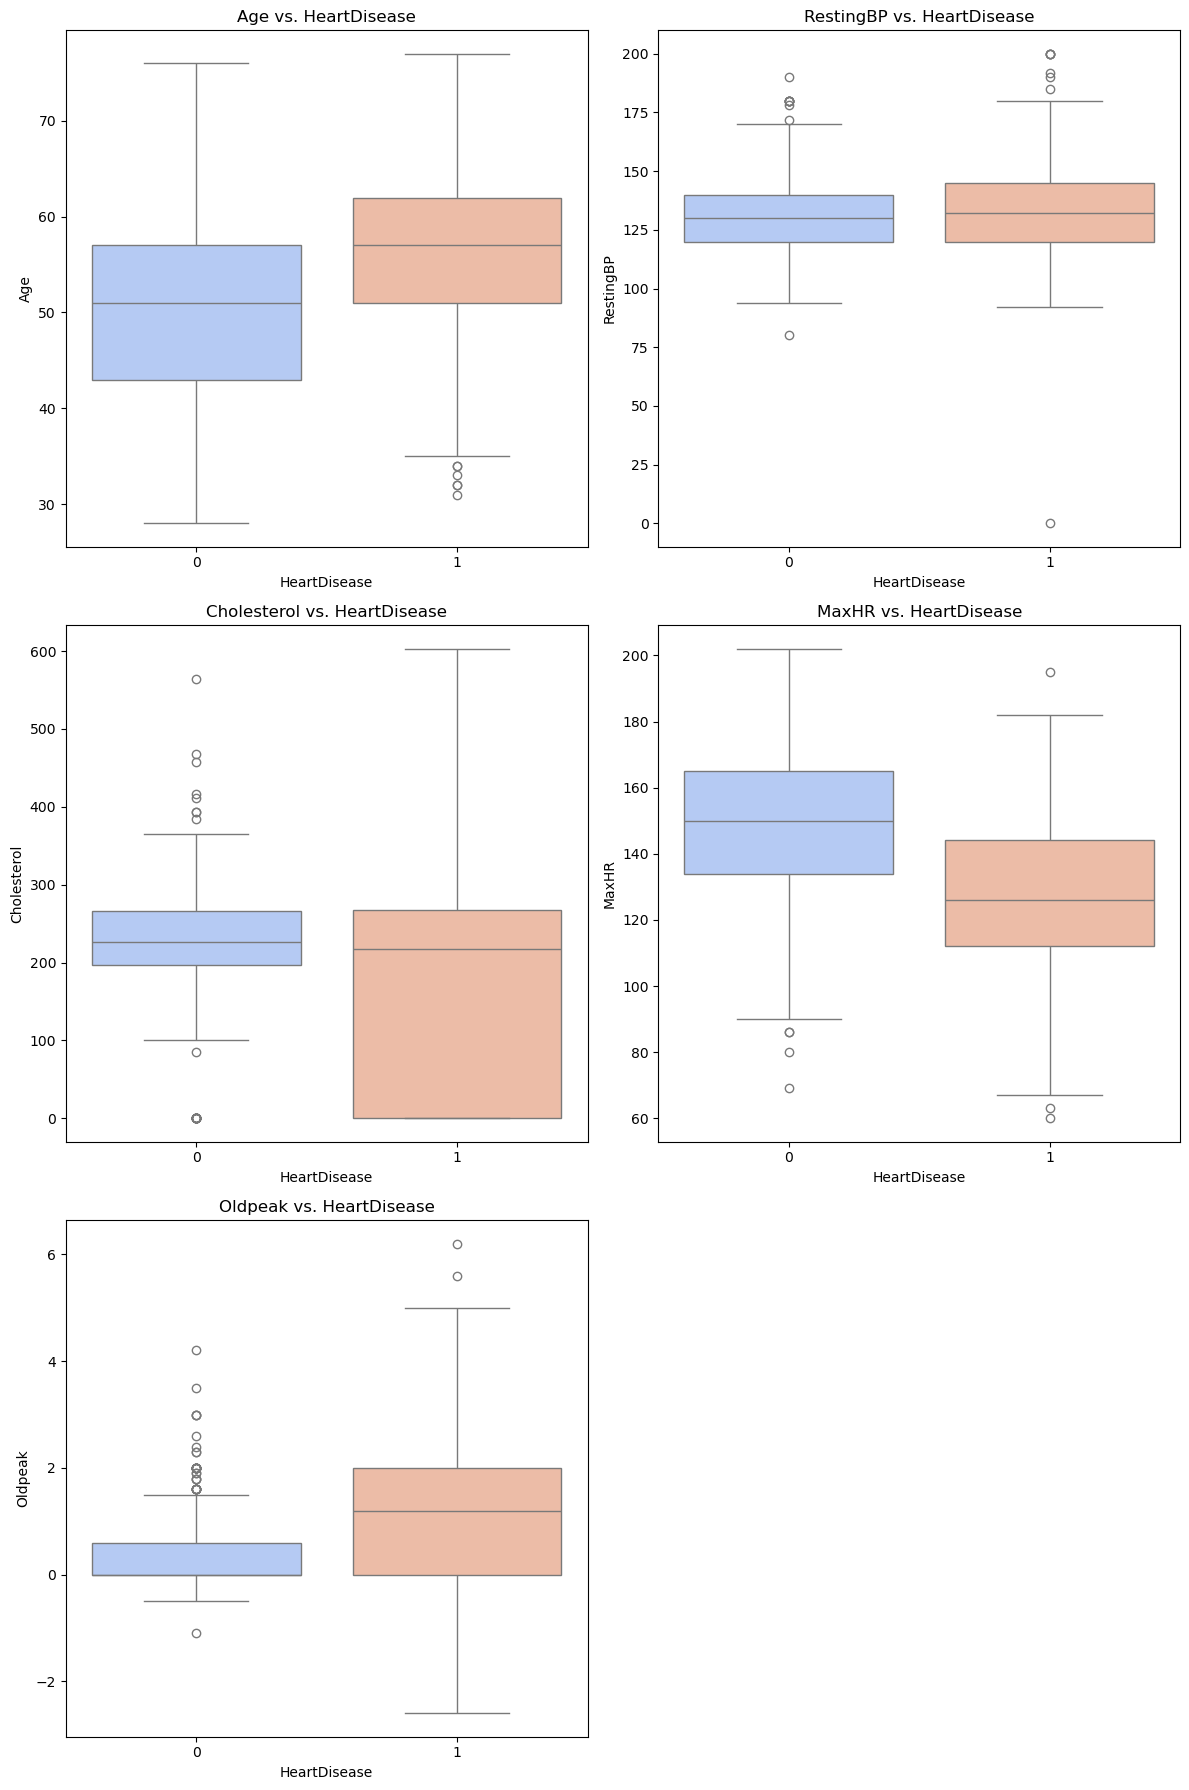

In [14]:
n_features = len(numeric_features)
ncols = 2
nrows = math.ceil(n_features / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6 * nrows))

axes = axes.ravel()

for i, feature in enumerate(numeric_features):
    sns.boxplot(
        data=df_heart, 
        x='HeartDisease', 
        y=feature, 
        ax=axes[i],
        palette='coolwarm'
    )
    axes[i].set_title(f"{feature} vs. HeartDisease")

#hide any leftover axes (in case n_features is odd)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### *Comments*
- Greater values of Age and Oldpeak appear more correlated with Heart Disease.
- Lower values of MaxHR appear more correlated with Heart Disease.

#### *b. Violin Plots*

/tmp/ipykernel_1358/1568419624.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1358/1568419624.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1358/1568419624.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1358/1568419624.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_1358/1568419624.py:11: Future

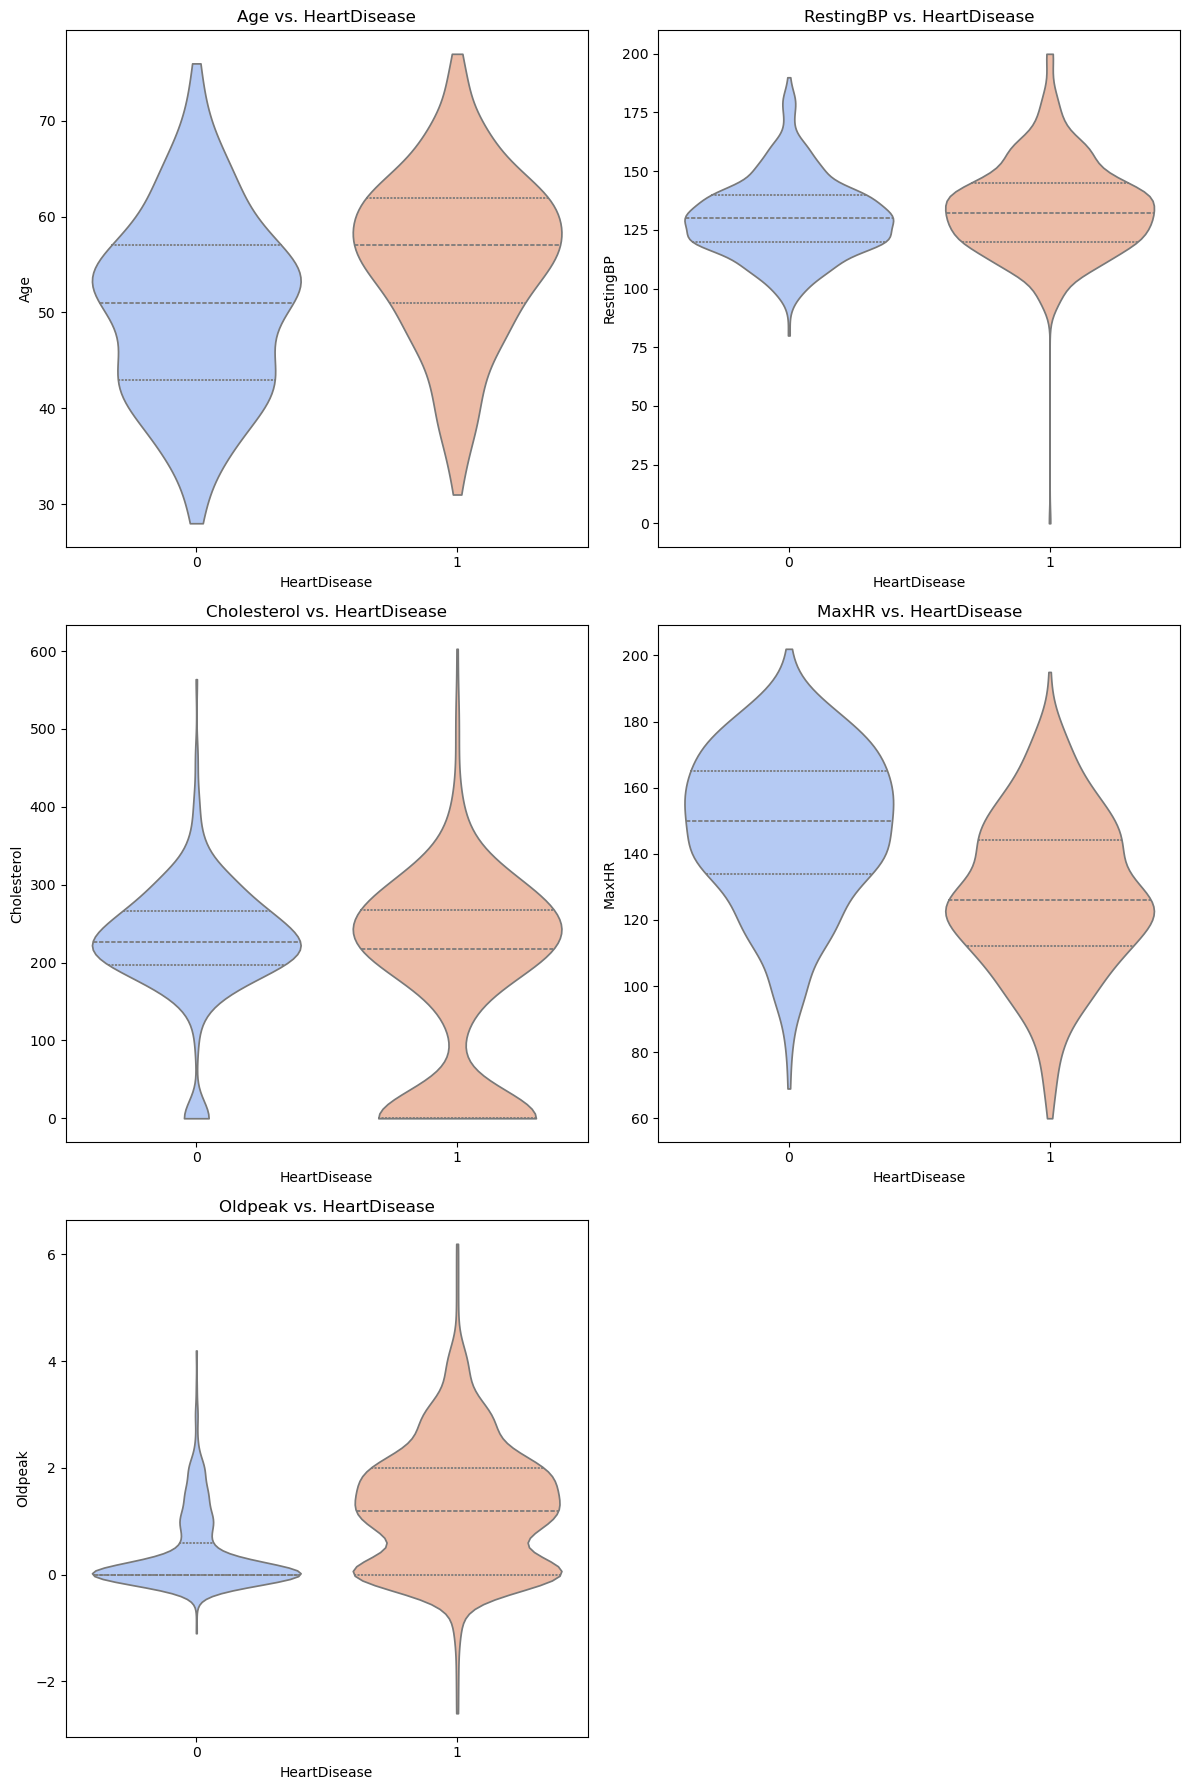

In [15]:
# generate violin plots

n_features = len(numeric_features)
ncols = 2
nrows = math.ceil(n_features / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6 * nrows))
axes = axes.ravel()

for i, feature in enumerate(numeric_features):
    sns.violinplot(
        data=df_heart,
        x='HeartDisease', # binary target on x‑axis
        y=feature, # numeric feature on y‑axis
        ax=axes[i],
        inner="quartile", # show quartiles
        cut=0, # trim violins at min/max of data
        palette='coolwarm'
    )
    axes[i].set_title(f"{feature} vs. HeartDisease")

# hide any leftover axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### *Comments*
- Greater values of Age and Oldpeak appear more correlated with Heart Disease.
- Lower values of MaxHR appear more correlated with Heart Disease.
- (Similar observations as those noted in the box plots)

#### *c. Scatter Plots (Numerical Feature vs Target)*

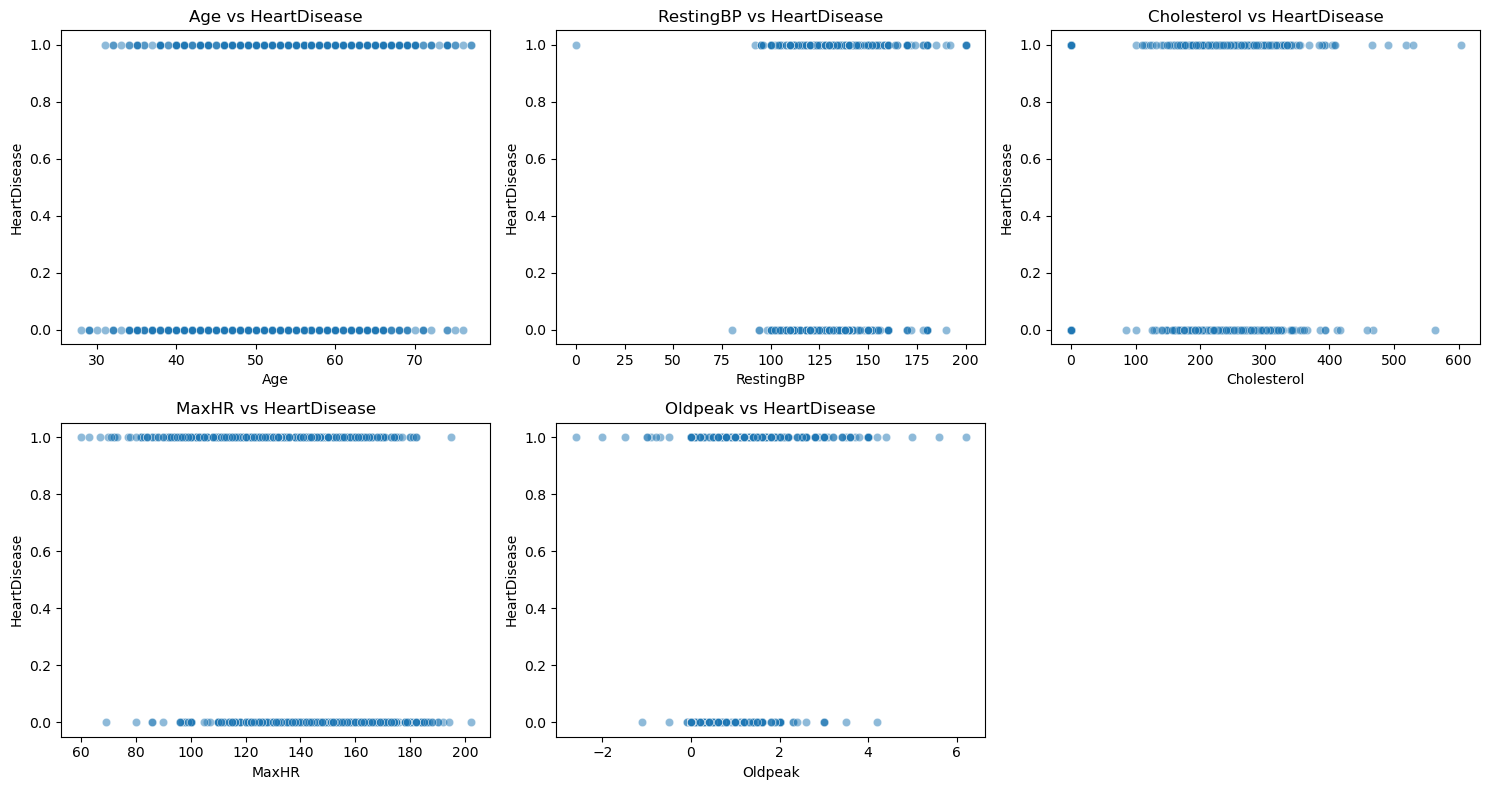

In [16]:
n_cols = 3 # want 3 columns
n_plots = len(numeric_features) * len(target_variables)
n_rows = math.ceil(n_plots / n_cols) # smallest row count that fits everything

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(5 * n_cols, 4 * n_rows),
                         squeeze=False)

axes_flat = axes.flatten() 
idx = 0

for feature in numeric_features:
    for target in target_variables:
        ax = axes_flat[idx]
        sns.scatterplot(data=df_heart,
                        x=feature, y=target,
                        alpha=0.5, ax=ax)
        ax.set_title(f"{feature} vs {target}")
        idx += 1

# hide any leftover blank panels 
for ax in axes_flat[idx:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


#### *Comments*
- Scatter plots don't seem to be the most useful format for visualizing this binary data. Because the y‑axis is binary, a scatterplot stacks all observations onto two horizontal lines, causing heavy over‑plotting that obscures class‑wise distribution patterns.
- Instead, to generate meaningful scatter plots, one must produce Numerical Feature vs Numerical Feature (w.r.t. Target Variable), as demonstrated in the next section.

## ---FEATURES VS. FEATURES---

### (i) Numerical Feature vs Numerical Feature, w.r.t. Target Variable (Heart Disease) - Scatter Plots

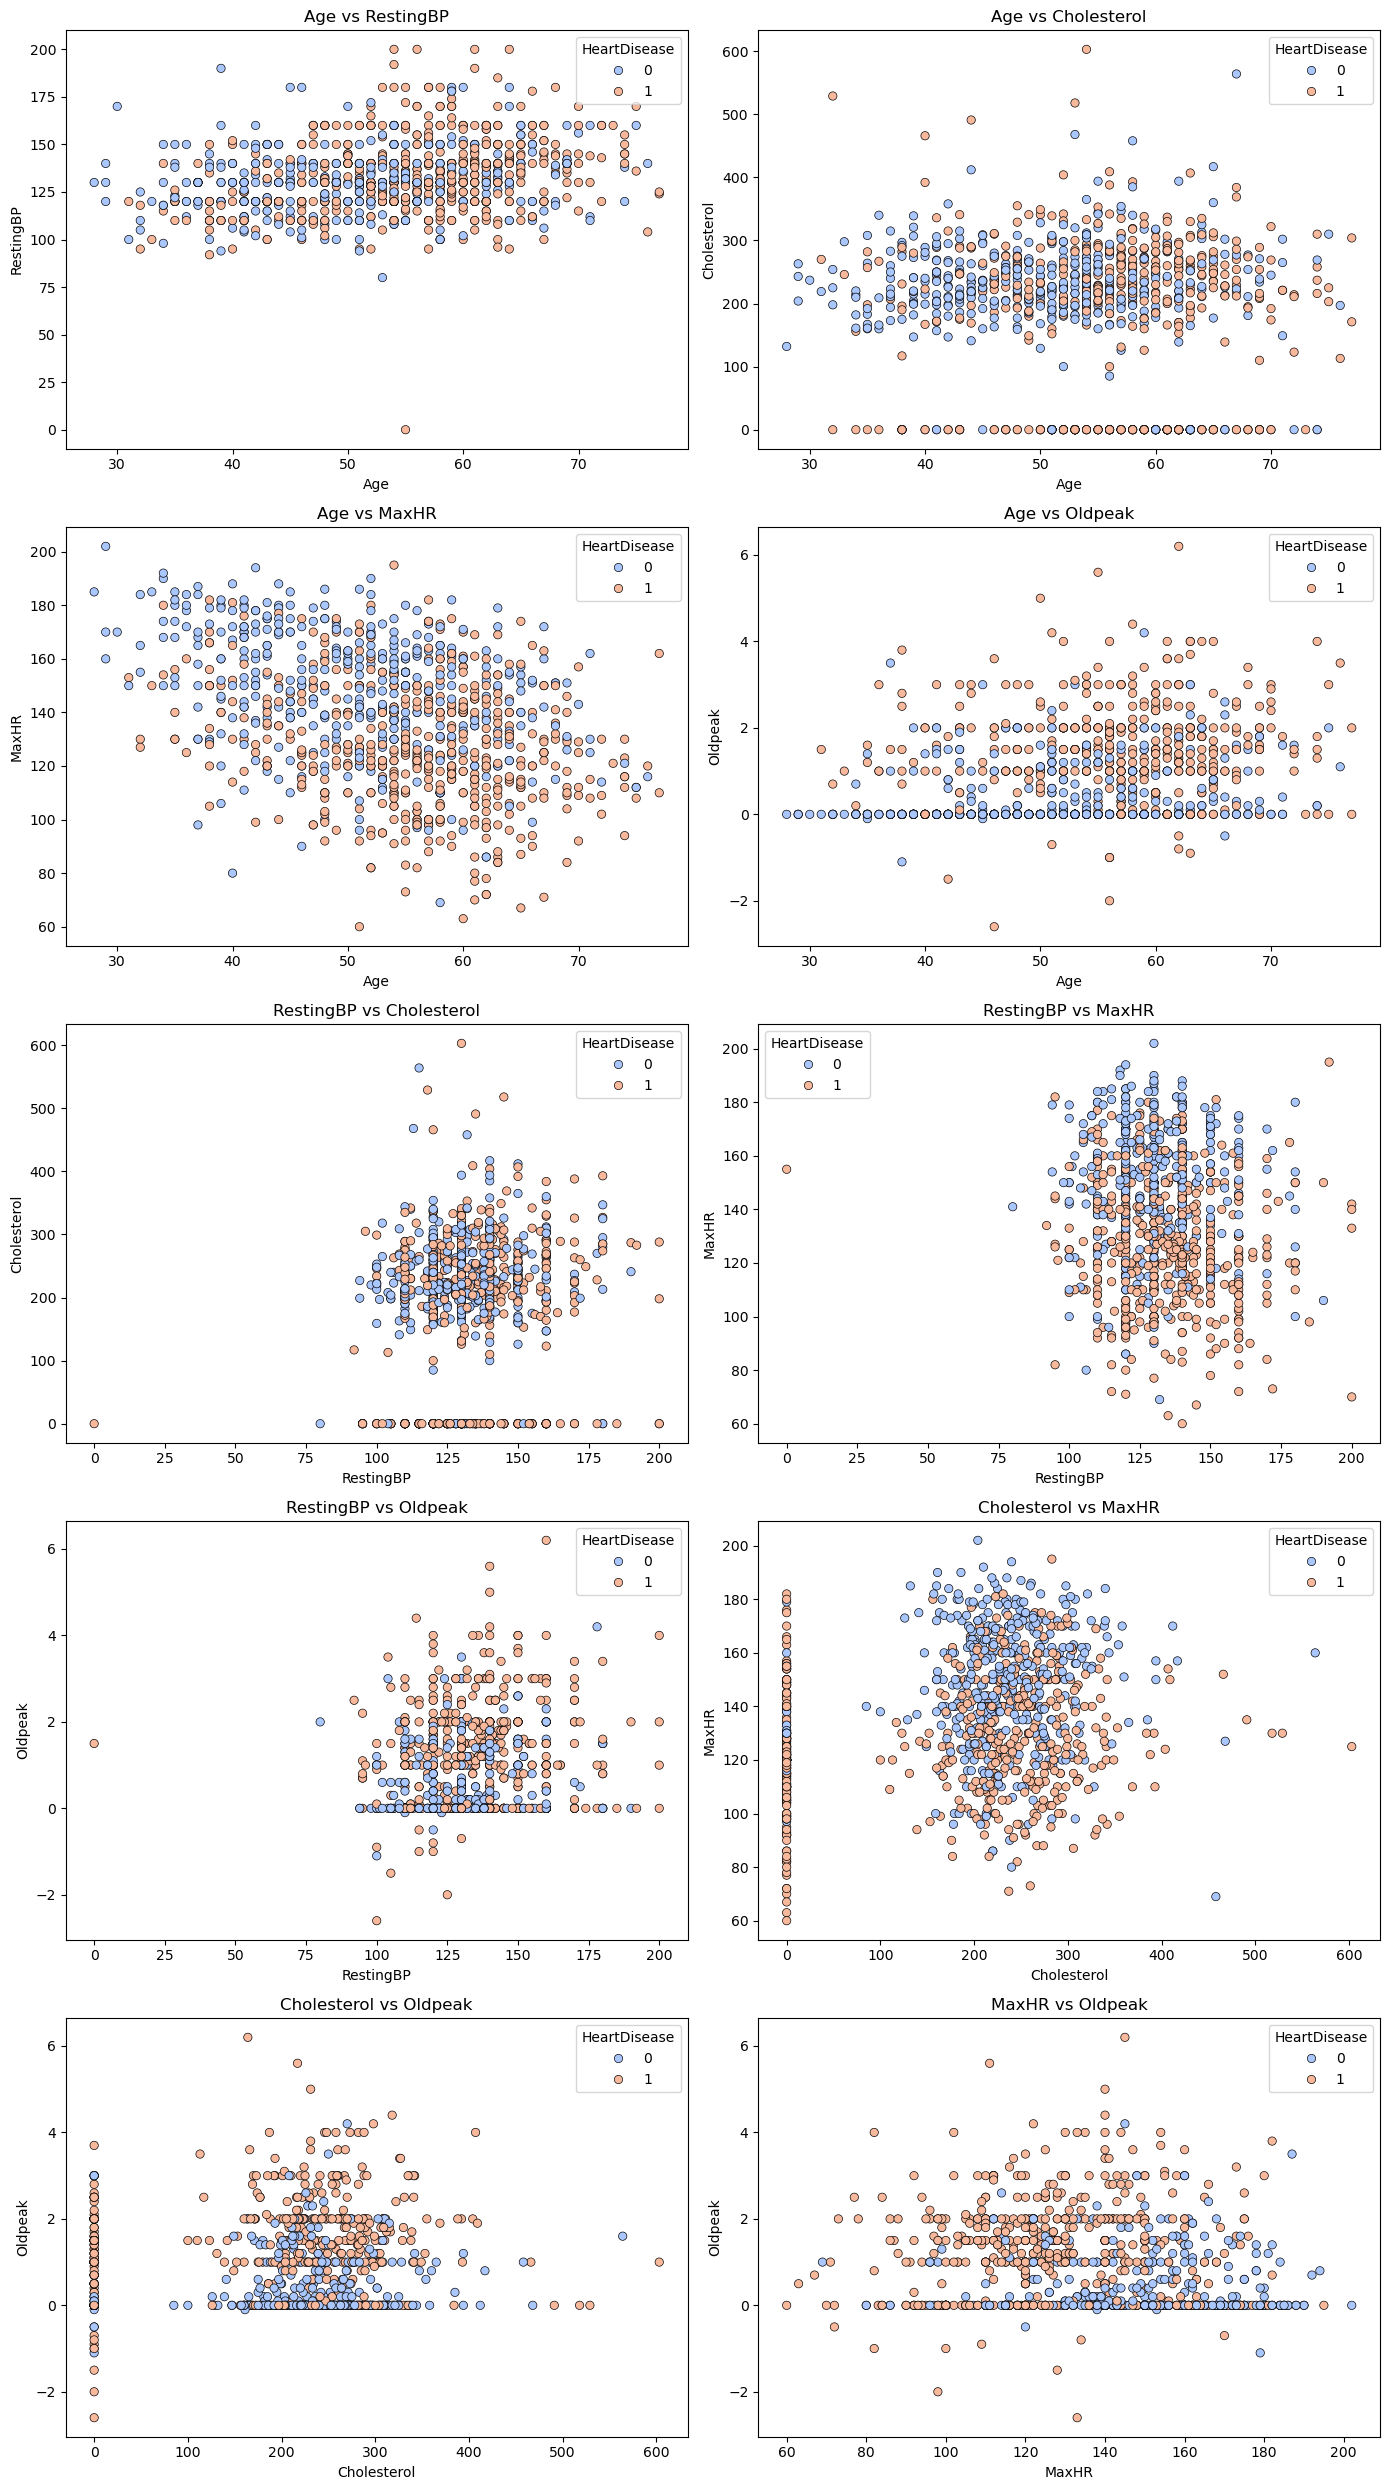

In [17]:
pairs = [(i, j) for i in range(len(numeric_features))
                  for j in range(i + 1, len(numeric_features))]
n_cols = 2
n_rows = math.ceil(len(pairs) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(7 * n_cols, 5 * n_rows),
                         squeeze=False)
axes_flat = axes.flatten()

for k, (i, j) in enumerate(pairs):
    ax = axes_flat[k]
    sns.scatterplot(df_heart,
                    x=numeric_features[i],
                    y=numeric_features[j],
                    hue='HeartDisease',
                    palette='coolwarm',
                    edgecolor='black',
                    ax=ax)
    ax.set_title(f"{numeric_features[i]} vs {numeric_features[j]}")
    ax.legend(title='HeartDisease')

# Hide any leftover empty panels
for ax in axes_flat[len(pairs):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


#### *Comments*
- Older age (>50) paired with slower HR (<120) appears associated with greater rate of heart disease.
- Slower HR (<120) appears associated with greater rate of heart disease across all of the horizontal variables.
- Greater Oldpeak appears associated with greater rate of heart disease across all ages (and across all of the other horizontal variables).

### (ii) Numerical Features vs Categorical Features, w.r.t. Target Variable (HeartDisease) - Strip Plots


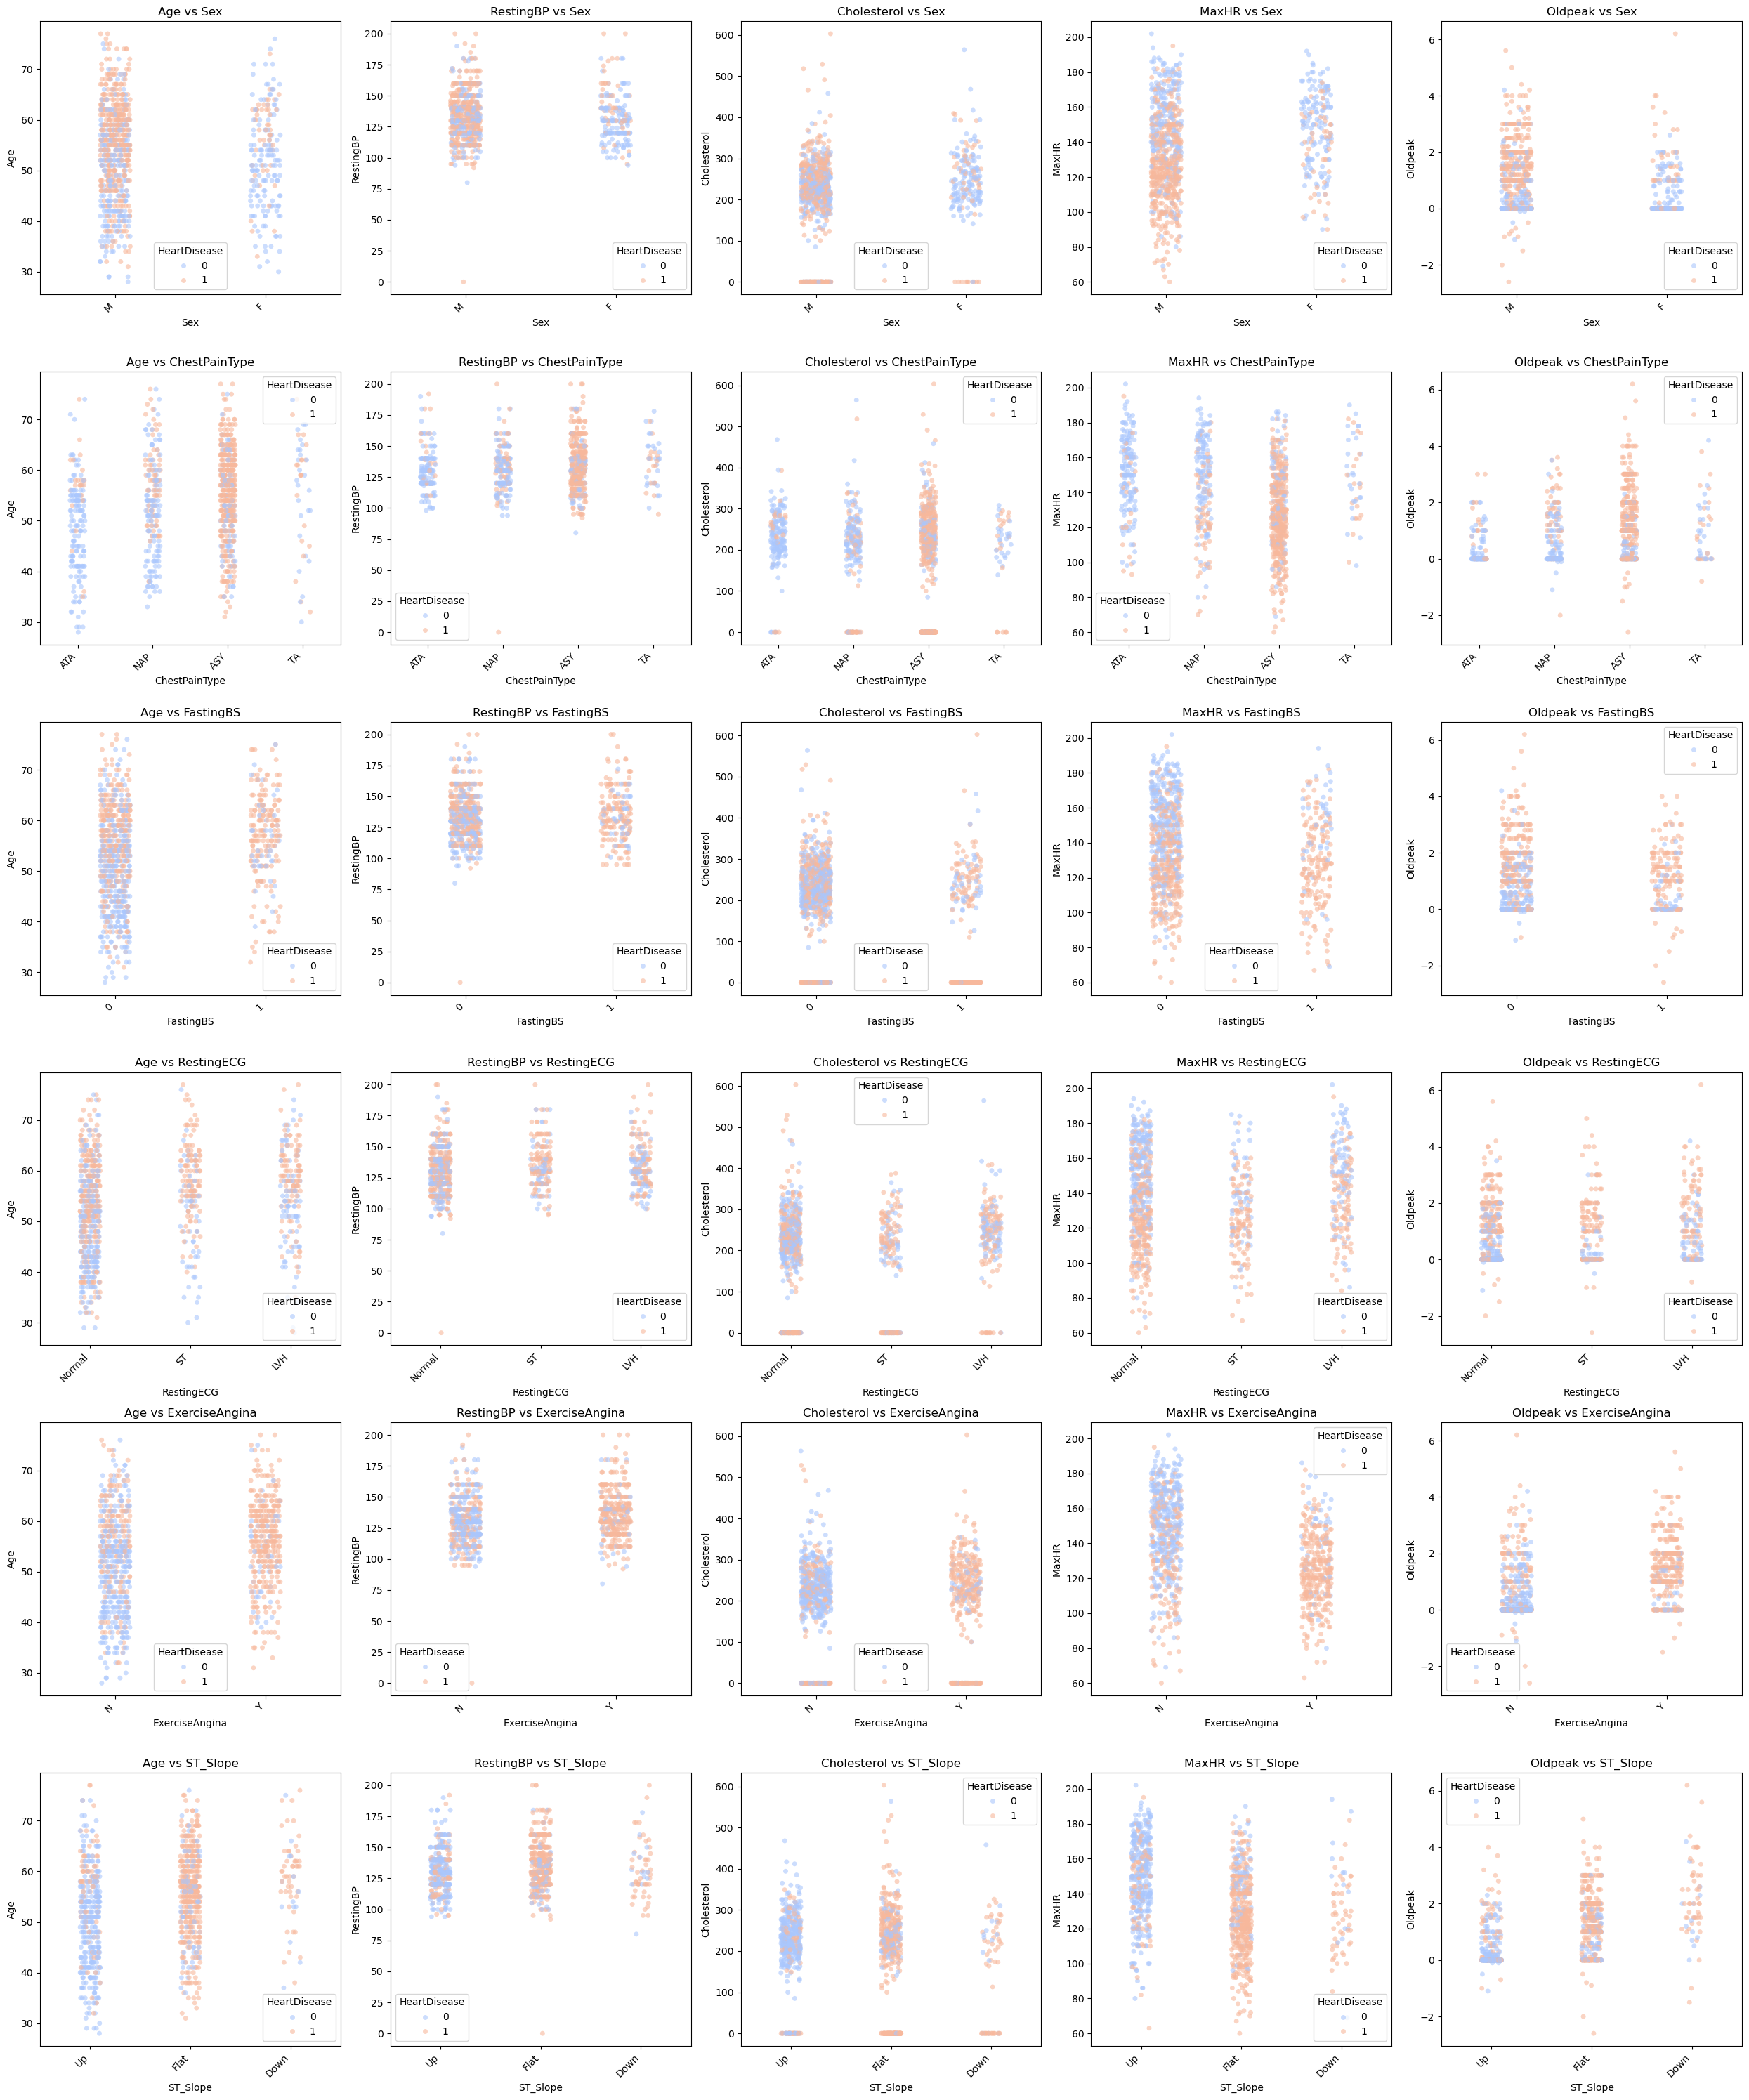

In [18]:
# all combinations of numeric and categorical features
pairs = [(cat, num) for cat in categorical_features for num in numeric_features]

n_cols = 5 # want 5 columns                                          
n_rows = math.ceil(len(pairs) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(5 * n_cols, 5 * n_rows),
                         squeeze=False)
axes = axes.flatten()

for idx, (cat, num) in enumerate(pairs):
    ax = axes[idx]

    sns.stripplot(data=df_heart,
                  x=cat, y=num,
                  hue='HeartDisease',
                  palette='coolwarm',
                  dodge=False, # overlay the two target classes horizontally
                  alpha=0.6,
                  ax=ax)

    ax.set_title(f"{num} vs {cat}")
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    

# hide any unused panels
for ax in axes[len(pairs):]:
    ax.set_visible(False)

fig.tight_layout()
plt.show()


#### *Comments*
- Sex: Heart‑disease cases cluster in men across the full feature range—especially age > 50, Oldpeak > 0, and MaxHR < 140. The female sample is more sparse.
- ChestPainType: The asymptomatic (ASY) class is associated with greatest rate of heart disease across every numerical feature.
- FastingBS: Age > 50 shows high event density regardless of FBS status. Hypertensive range RestingBP (> 100 mmHg) plus FBS = 1 elevates risk, whereas cholesterol does not notably stratify events. In FBS = 0 patients, MaxHR < 130 still marks higher risk.
- RestingECG: Any abnormal trace (ST or LVH) is typically associated with events from approximately age 40 upward. Normal traces show events mainly when MaxHR < 140 or Oldpeak > 0.
- ExerciseAngina: Presence of exercise‑induced angina shows a strong, uniform positive association with heart diseaese across all numerical features.
- ST_Slope: Probability of heart disease appears to be Flat > Down > Up, with the Flat slope clearly the highest‑risk category across numerical features.

## ---OVERALL EDA INSIGHTS---

This is a summary of some of the insights we obtained from EDA of the heart disease dataset.

#### Categorical features – risk order (highest > lowest)

- Sex: Male > Female
- Chest Pain Type: ASY > NAP > ATA > TA
- Fasting Blood Sugar (FBS): 1 > 0
- Resting ECG: Normal > ST > LVH
- Exercise‑Induced Angina: Angina present > None
- ST Segment Slope: Flat > Up > Down

#### Numerical features – ranges associated with prominent heart disease rates
- Age: ≥ 50 yr
- Resting BP: 100 ‑ 180 mmHg
- Cholesterol: 120 ‑ 350 mg/dL
- Max Heart Rate: < 140 bpm
- Oldpeak: > 1 mm

#### Overall pattern
- Middle‑aged men (≥ 50 yr) with asymptomatic chest pain, flat ST‑slope, exercise‑induced angina, and “normal” resting ECG appear to be the highest‑risk cohort. (Age ≥ 50  &  MaxHR < 140  &  Oldpeak > 0  &  ST‑Slope = Flat captures large proportion of positive cases.)
- Hyperglycaemia alone does not separate risk
- Serum cholesterol adds little extra discrimination within its 160‑340 mg/dL band.
- Hypertension becomes a stronger signal when paired with either FBS = 1, exercise‑induced angina, male, or flat ST slope.
- There is a moderate sample imbalance in sex, with only about 20% of the samples being measured from females.

## ---DATA PREPROCESSING---

#### Data splits (60:20:20 training:val:test)

In [19]:
# data splitting
X = df_heart.drop(columns=["HeartDisease"]) # drop target variables
y = df_heart[["HeartDisease"]] # df with target variables

# use single split for X and y for dev and test sets
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# now split dev set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=42) # 25% of 80% = 20%
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (550, 11)
X_val shape: (184, 11)
X_test shape: (184, 11)
y_train shape: (550, 1)
y_val shape: (184, 1)
y_test shape: (184, 1)


#### Apply StandardScaler to numerical features and OHE to categorical features

In [20]:
num_cols = X_train.select_dtypes(include="number").columns
cat_cols = X_train.select_dtypes(exclude="number").columns

# StandardScaler for numeric features and OHE for categorical features
preproc = ColumnTransformer(
    [("num", StandardScaler(), num_cols),
     ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='first'), cat_cols)], 
    remainder="drop"
) # add drop="First" if need to address multicollinearity in regression

# back up non-preprocessed data
X_train_original= X_train.copy()
X_val_original= X_val.copy()
X_test_original= X_test.copy()

# fit only on training data
preproc.fit(X_train)

# transform every split
X_train = preproc.transform(X_train)
X_val   = preproc.transform(X_val)
X_test  = preproc.transform(X_test)

## ---CORRELATION MATRIX---

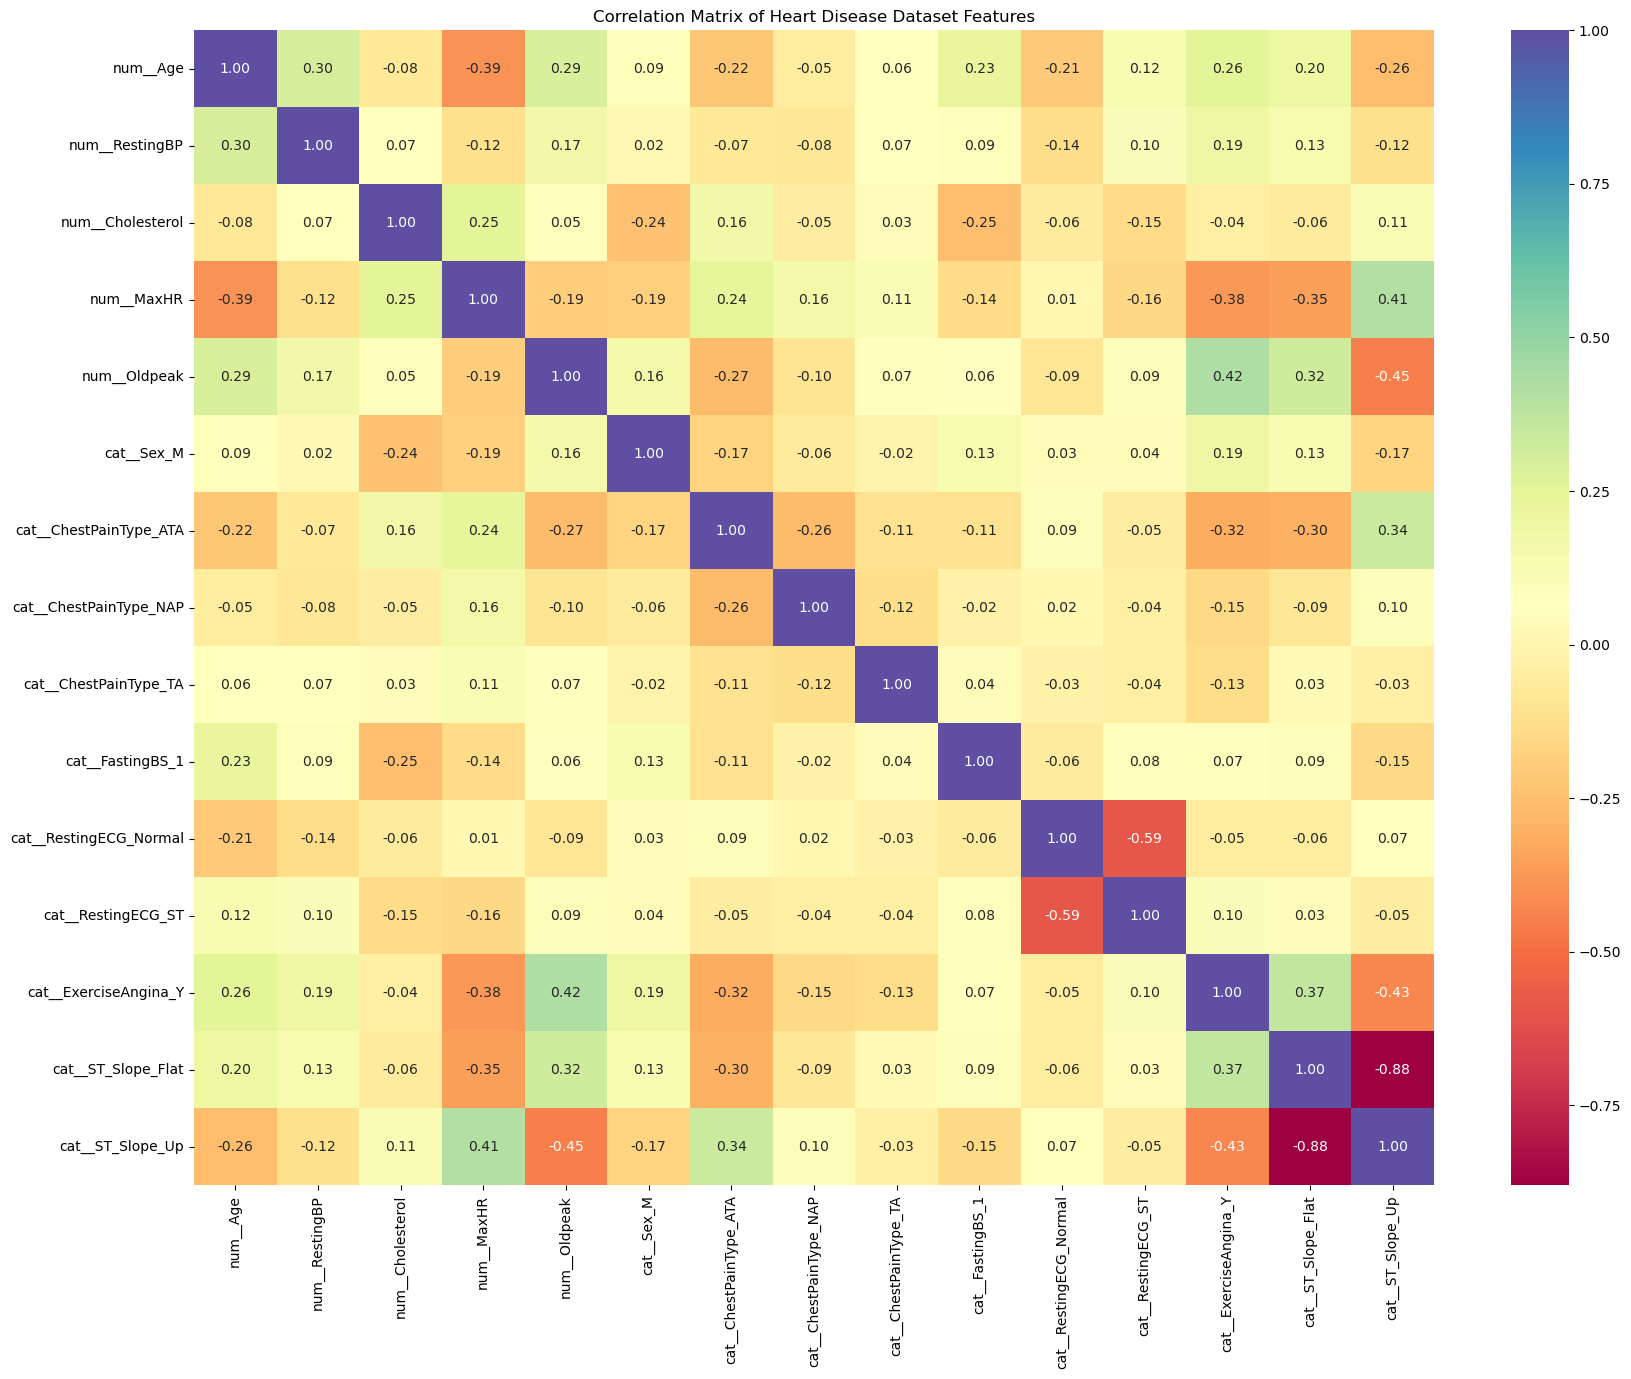

In [21]:
# Correlation matrix

# recreate the DataFrame with preprocessed data
feature_names = preproc.get_feature_names_out()
X_train_df = pd.DataFrame(X_train, columns=feature_names)
corr = X_train_df.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, cmap='Spectral', fmt='.2f') 
plt.title('Correlation Matrix of Heart Disease Dataset Features')
plt.show()

#### *Comments*
**A few noteworthy correlation pairs include:**
- Negative correlation between ST_Slope_Up and ST_Slope_Flat (-0.88) that is borderline extreme in magnitude. It is recommended to drop one of these columns for our regression models, due to potential impact of multicollinearity.
- Negative correlation between MaxHR and Age (-0.39). This corresponds with known information about how peak heart rates decrease with age.
- Negative correlation between ST_Slope_Up and ExerciseAngina_Y (-0.43). This corresponds with known information about how up-sloping ST segment during exertion usually reflects adequate myocardial perfusion (i.e. no exercise angina).
- Negative correlation between ST_Slope_Up and Oldpeak (-0.45).

## ---Statistical Tests---

We performed univariate feature selection using both Chi-Squared (for categorical features) and ANOVA F-test (for continuous features) to identify the most relevant predictors for the target variable.

### ---Chi-Squared---

In [22]:
# Chi2 score
X_cat = preproc.named_transformers_['cat'].transform(X_train_original[cat_cols])
chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(X_cat, y_train)
chi2_scores = pd.Series(chi2_selector.scores_, index=preproc.named_transformers_['cat'].get_feature_names_out(cat_cols))
print("Chi2 Scores: ", chi2_scores.sort_values(ascending=False))

Chi2 Scores:  ST_Slope_Up          111.914396
ST_Slope_Flat         85.576271
ExerciseAngina_Y      83.751851
ChestPainType_ATA     62.255218
FastingBS_1           21.412963
ChestPainType_NAP     17.747910
Sex_M                 13.097735
RestingECG_ST          2.535025
ChestPainType_TA       0.917359
RestingECG_Normal      0.544409
dtype: float64


/tmp/ipykernel_1358/1166402922.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=chi2_df, x='Chi2', y='Feature', palette='viridis')


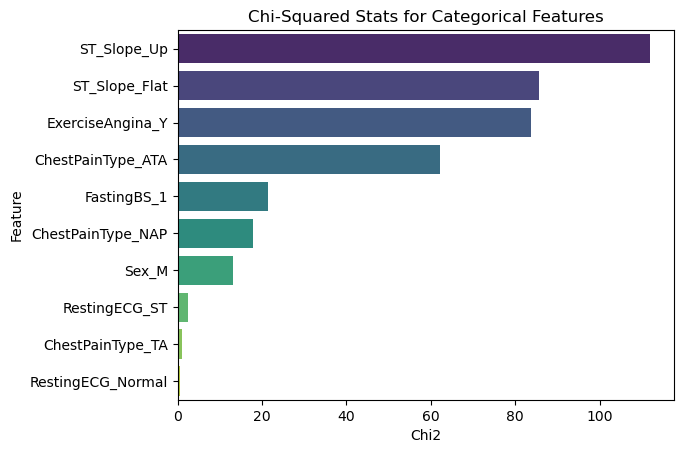

In [23]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = preproc.named_transformers_['cat'].transform(X_train_original[cat_cols])
chi2_stats, p_vals = chi2(X_cat, y_train)

feature_names = preproc.named_transformers_['cat'].get_feature_names_out(cat_cols)

chi2_df = pd.DataFrame({'Feature': feature_names, 'Chi2': chi2_stats})
chi2_df.sort_values(by='Chi2', ascending=False, inplace=True)

sns.barplot(data=chi2_df, x='Chi2', y='Feature', palette='viridis')
plt.title("Chi-Squared Stats for Categorical Features")
plt.show()

#### *Comments*
The Chi-Squared test was applied to analyze the statistical relationship between each categorical feature and the target variable, HeartDisease. This test evaluates whether the distributions of categorical variables are independent of the outcome. The results showed that several features, including ChestPainType, ST_Slope, and Sex, had very low p-values, indicating a strong dependency on the target variable. For instance, ChestPainType had a p-value close to zero, which suggests that the distribution of chest pain types varies significantly between patients with and without heart disease. This supports the earlier findings from SHAP, reinforcing the relevance of these features.

### ---ANOVA---

In [24]:
#ANOVA
X_num = X_train_original[num_cols]
f_selector = SelectKBest(score_func=f_classif, k='all')
f_selector.fit(X_num, y_train.values.ravel())
f_scores = pd.Series(f_selector.scores_, index=num_cols)
print("ANOVA Scores: ", f_scores.sort_values(ascending=False))

ANOVA Scores:  Oldpeak        115.109502
MaxHR          105.237574
Age             47.305081
Cholesterol     39.405901
RestingBP        8.262528
dtype: float64


/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/tmp/ipykernel_1358/3758388941.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=f_df, x='F-Value', y='Feature', palette='magma')


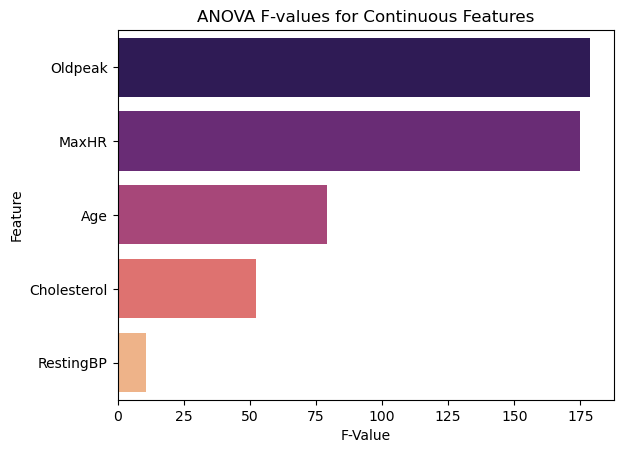

In [25]:
f_values, p_vals = f_classif(X[num_cols], y)
f_df = pd.DataFrame({'Feature': num_cols, 'F-Value': f_values})
f_df.sort_values(by='F-Value', ascending=False, inplace=True)

sns.barplot(data=f_df, x='F-Value', y='Feature', palette='magma')
plt.title("ANOVA F-values for Continuous Features")
plt.show()


#### *Comments*
Finally, to validate the statistical significance of the input features, ANOVA (Analysis of Variance) F-tests were conducted. ANOVA tests whether there are statistically significant differences between the means of different feature groups relative to the target variable. The F-values and corresponding p-values helped determine which features had a strong linear relationship with heart disease. Features such as Oldpeak, ChestPainType, ST_Slope, and MaxHR again emerged as significant, aligning well with the SHAP and Chi-Squared findings. This agreement between SHAP, Chi-Squared, and ANOVA adds credibility to the model’s interpretability and confirms that these features are statistically and predictively important.

## ---SUPERVISED LEARNING---

### (i) Decision Trees

In [26]:
dtree = DecisionTreeClassifier(criterion="entropy", random_state=42)
dtree.fit(X_train, y_train)
dev_df_pred = dtree.predict(X_train)
test_df_pred = dtree.predict(X_test)
print(classification_report(y_train, dev_df_pred))
print(classification_report(y_test, test_df_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       255
           1       1.00      1.00      1.00       295

    accuracy                           1.00       550
   macro avg       1.00      1.00      1.00       550
weighted avg       1.00      1.00      1.00       550

              precision    recall  f1-score   support

           0       0.72      0.82      0.76        77
           1       0.85      0.77      0.81       107

    accuracy                           0.79       184
   macro avg       0.79      0.79      0.79       184
weighted avg       0.80      0.79      0.79       184



best max depth: 8
best max depth accuracy: 0.8913043478260869


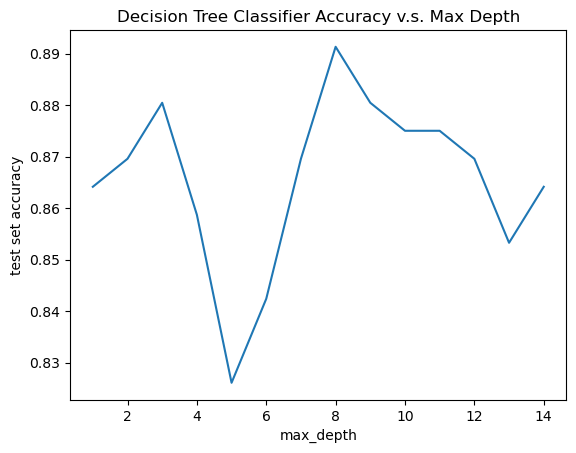

In [27]:
max_depths = np.arange(1, 15)
scores = []
max_md_score = 0
best_max_depth = None
for d in max_depths:
    dtree = DecisionTreeClassifier(criterion="entropy", max_depth=d, random_state=42)
    dtree.fit(X_train, y_train)
    score = dtree.score(X_val, y_val)
    scores.append(score)
    if score > max_md_score:
        best_max_depth = d
        max_md_score = score

plt.plot(max_depths, scores)
plt.xlabel("max_depth")
plt.ylabel("test set accuracy")
plt.title("Decision Tree Classifier Accuracy v.s. Max Depth")
print(f"best max depth: {best_max_depth}")

print(f"best max depth accuracy: {max_md_score}")

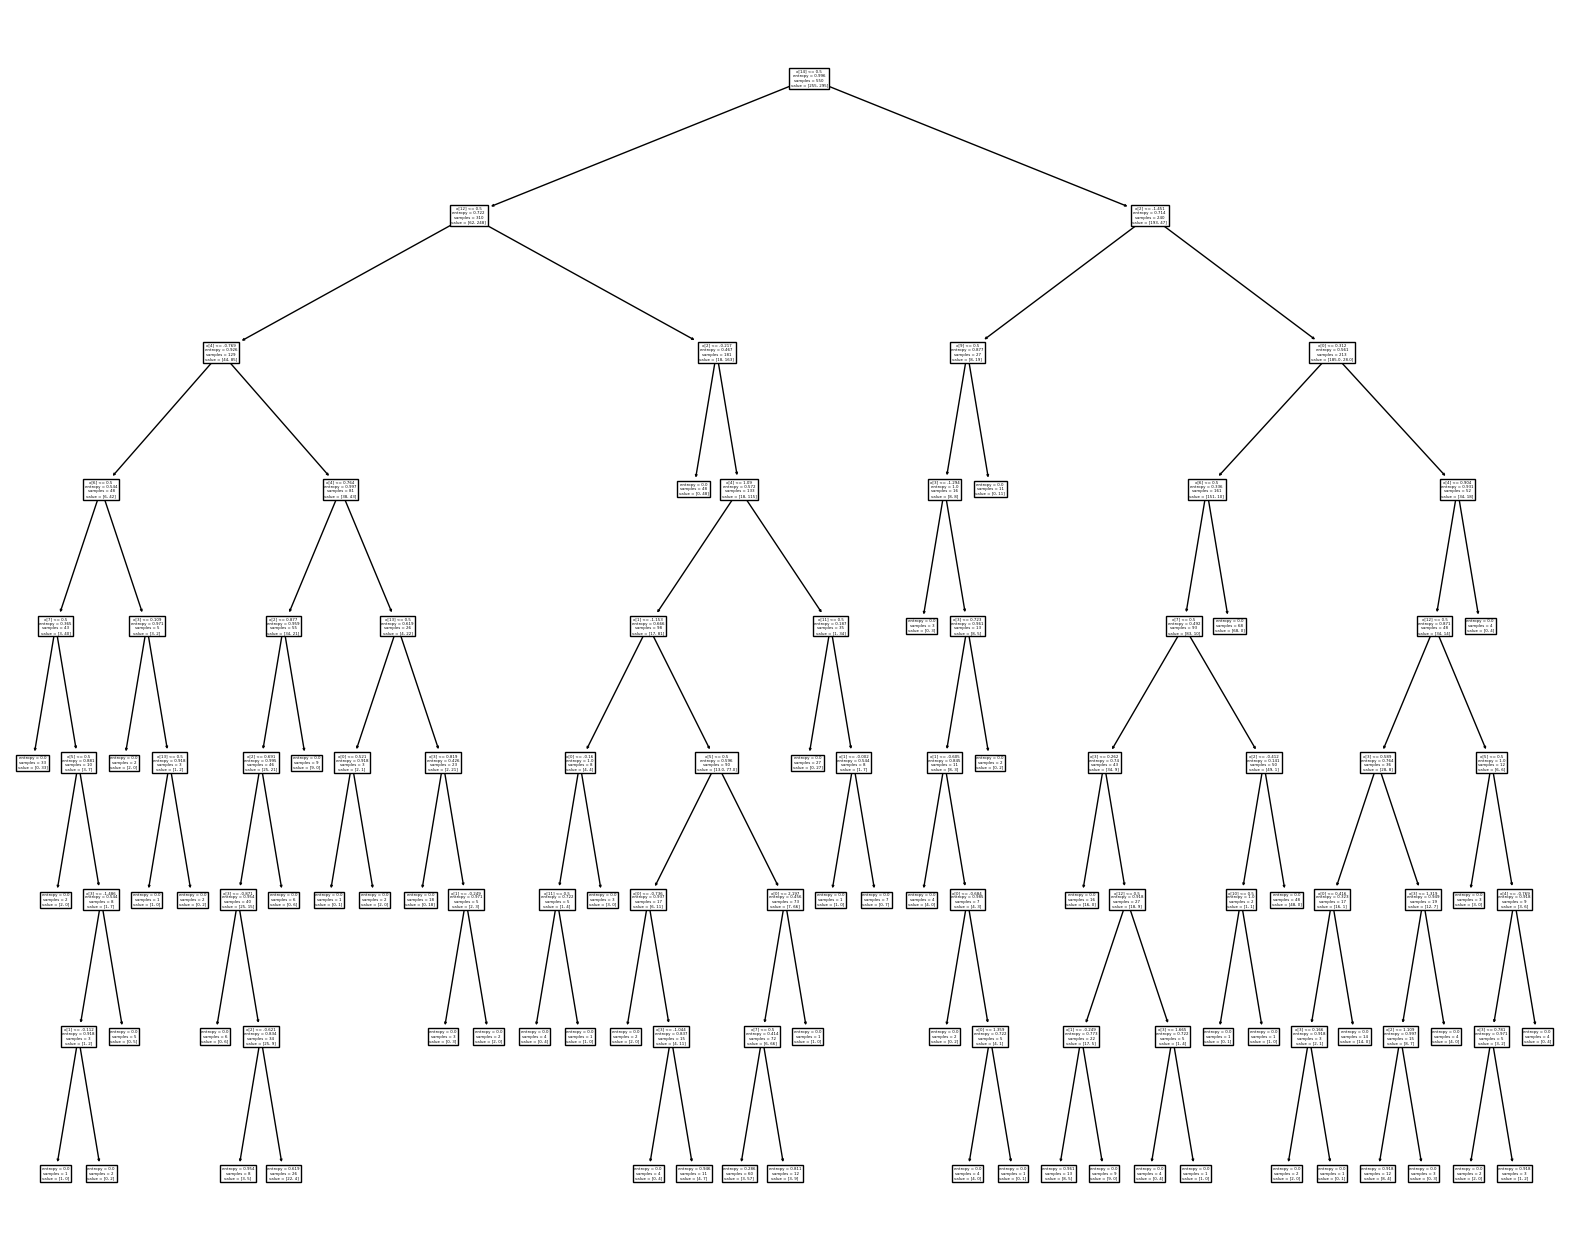

In [28]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 16))
dtree = DecisionTreeClassifier(criterion="entropy", max_depth=best_max_depth, random_state=42)
dtree.fit(X_train, y_train)
plot_tree(dtree)
plt.show()

The best ccp alpha is 0.007714146815751094
The best ccp alpha accuracy is 0.9019958099600521


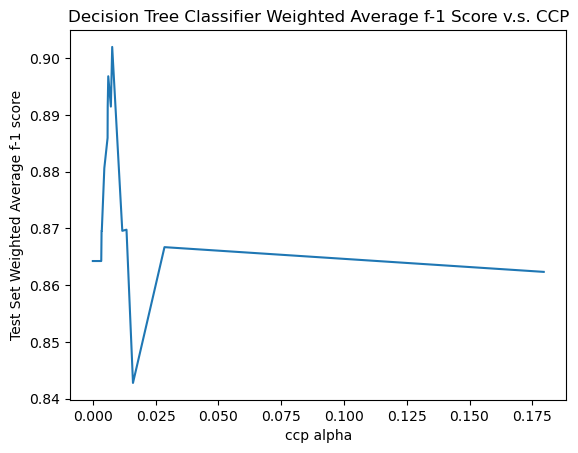

In [29]:
ccp_tree = DecisionTreeClassifier()
path = ccp_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas= path.ccp_alphas

ccp_score = []
max_score = 0
best_ccp = None
for ccp_a in ccp_alphas:
    dtree = DecisionTreeClassifier(criterion="entropy", ccp_alpha=ccp_a, random_state=42)
    dtree.fit(X_train, y_train)
    score = f1_score(y_val, dtree.predict(X_val), average="weighted")
    ccp_score.append(score)
    if score > max_score:
        best_ccp = ccp_a
        max_score = score

plt.plot(ccp_alphas, ccp_score)
plt.xlabel("ccp alpha")
plt.ylabel("Test Set Weighted Average f-1 score")
plt.title("Decision Tree Classifier Weighted Average f-1 Score v.s. CCP")
print(f"The best ccp alpha is {best_ccp}")
print(f"The best ccp alpha accuracy is {max_score}")

In [30]:
best_param_dtree = DecisionTreeClassifier(criterion="entropy", ccp_alpha=best_ccp, max_depth=best_max_depth, random_state=42)
best_param_dtree.fit(X_train, y_train)
dev_df_pred = best_param_dtree.predict(X_train)
test_df_pred = best_param_dtree.predict(X_test)
print(classification_report(y_train, dev_df_pred))
print(classification_report(y_test, test_df_pred))


              precision    recall  f1-score   support

           0       0.87      0.91      0.89       255
           1       0.92      0.88      0.90       295

    accuracy                           0.89       550
   macro avg       0.89      0.90      0.89       550
weighted avg       0.90      0.89      0.89       550

              precision    recall  f1-score   support

           0       0.74      0.87      0.80        77
           1       0.89      0.79      0.84       107

    accuracy                           0.82       184
   macro avg       0.82      0.83      0.82       184
weighted avg       0.83      0.82      0.82       184



Text(0, 0.5, 'Importance')

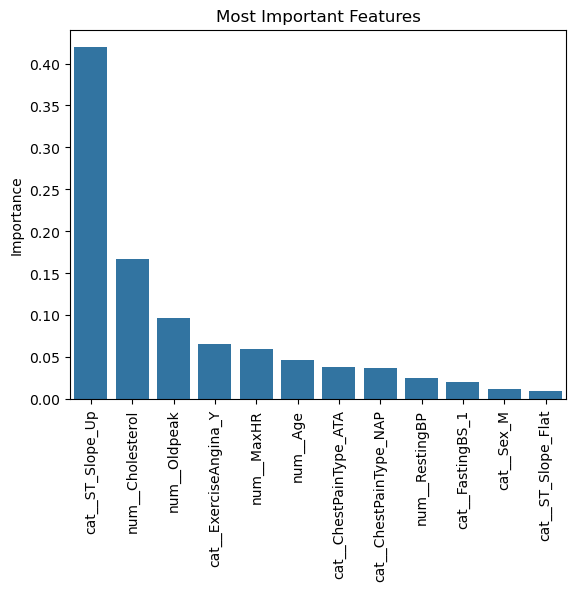

In [31]:
features = X_train_df.columns
feat_imps = zip(features, best_param_dtree.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key=lambda x: x[1], reverse=True)))
sns.barplot(x=feats, y=imps)
plt.xticks(rotation=90)
plt.title("Most Important Features")
plt.ylabel("Importance")

### (ii) Random Forest

In [32]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85        77
           1       0.90      0.87      0.89       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [33]:
n_trees = [10, 50, 100, 200, 300]
n_features = [2, 3, 4, 5, 6, 7, 8]

best_nt = None
best_nf = None
oobs = []
nts = []
nfs = []
best_oob = 0
for nt in n_trees:
    for nf in n_features:
        rfi = RandomForestClassifier(n_estimators=nt, max_features=nf,random_state=42, oob_score=True, warm_start=True)
        rfi.fit(X_train, y_train)
        oob = rfi.oob_score_
        oobs.append(oob)
        nts.append(nt)
        nfs.append(nf)
        if oob > best_oob:
            best_oob = oob
            best_nf = nf
            best_nt = nt
print(f"best number of trees: {best_nt}; best number of features: {best_nf}")

/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


best number of trees: 200; best number of features: 2


Text(0.5, 1.0, 'OOB Score v.s. Number of Trees')

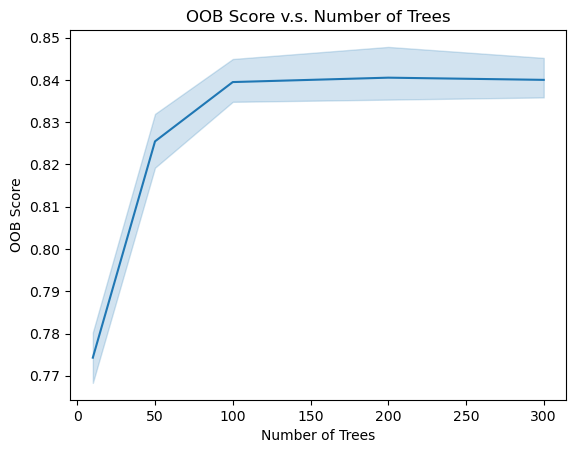

In [34]:
sns.lineplot(x=nts, y=oobs)

plt.xlabel("Number of Trees")
plt.ylabel("OOB Score")
plt.title("OOB Score v.s. Number of Trees")

Text(0.5, 1.0, 'OOB Score v.s. Number of Features')

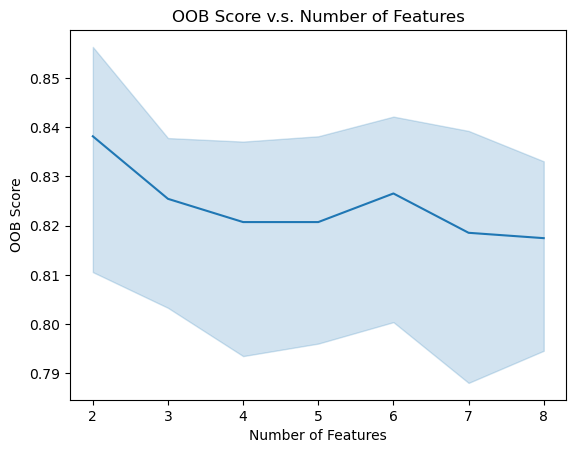

In [35]:
sns.lineplot(x=nfs, y=oobs)

plt.xlabel("Number of Features")
plt.ylabel("OOB Score")
plt.title("OOB Score v.s. Number of Features")

In [36]:
best_rf = RandomForestClassifier(n_estimators=best_nt, max_features=best_nf, random_state=42, warm_start=True)
best_rf.fit(X_train, y_train)
dev_df_y_pred_best_rf = best_rf.predict(X_train)
test_df_y_pred_best_rf = best_rf.predict(X_test)

print(classification_report(y_train, dev_df_y_pred_best_rf))
print(classification_report(y_test, test_df_y_pred_best_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       255
           1       1.00      1.00      1.00       295

    accuracy                           1.00       550
   macro avg       1.00      1.00      1.00       550
weighted avg       1.00      1.00      1.00       550

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        77
           1       0.90      0.90      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Text(0, 0.5, 'Importance')

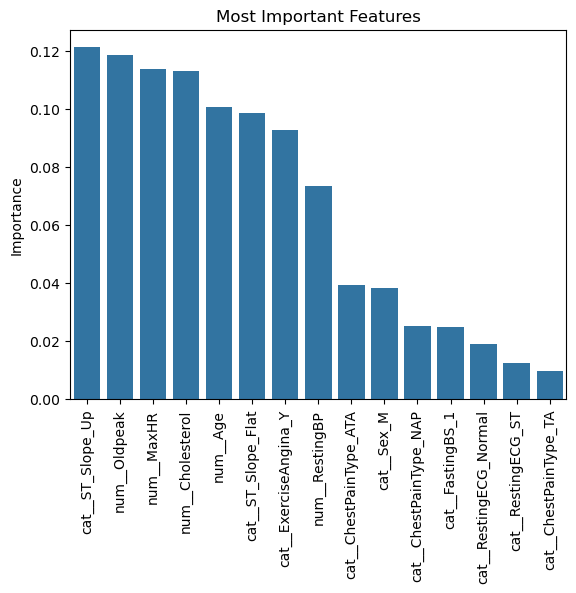

In [37]:
feat_imps_rf = zip(features, best_rf.feature_importances_)
feats_rf, imps_rf = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps_rf)), key=lambda x: x[1], reverse=True)))
sns.barplot(x=feats_rf, y=imps_rf)
plt.xticks(rotation=90)
plt.title("Most Important Features")
plt.ylabel("Importance")

### (iii) Boosting

In [38]:
#boosting
hp_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_iter': [10, 50, 100],
    'max_depth': [3, 4, 5]
}
grid_search = GridSearchCV(estimator=HistGradientBoostingClassifier(random_state=42), param_grid=hp_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

print(f"Best score: {grid_search.best_score_:.3f}")
print(f"Best parameters: {grid_search.best_params_}")

print(f"Test score:", grid_search.score(X_test, y_test))

/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

Best score: 0.858
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'max_iter': 100}
Test score: 0.8858695652173914


/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [39]:
best_max_iter = grid_search.best_params_["max_iter"]
best_learning_rate = grid_search.best_params_["learning_rate"]
best_max_depth = grid_search.best_params_["max_depth"]
best_hgbc = HistGradientBoostingClassifier(max_iter=best_max_iter, learning_rate=best_learning_rate, max_depth=best_max_depth, random_state=42)
best_hgbc.fit(X_train, y_train)
dev_df_y_pred_best_hgbc = best_hgbc.predict(X_train)
test_df_y_pred_best_hgbc = best_hgbc.predict(X_test)

print(classification_report(y_train, dev_df_y_pred_best_hgbc))
print(classification_report(y_test, test_df_y_pred_best_hgbc))

/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.91      0.87      0.89       255
           1       0.89      0.93      0.91       295

    accuracy                           0.90       550
   macro avg       0.90      0.90      0.90       550
weighted avg       0.90      0.90      0.90       550

              precision    recall  f1-score   support

           0       0.87      0.86      0.86        77
           1       0.90      0.91      0.90       107

    accuracy                           0.89       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184



In [40]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 20.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 18.8 MB/s eta 0:00:0000:0100:01


In [41]:
from xgboost import XGBClassifier
xgb_grid = {
    'eta': [0.05, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search_xgb = GridSearchCV(estimator=XGBClassifier(random_state=42), param_grid=xgb_grid, cv=5, scoring="accuracy")
grid_search_xgb.fit(X_train, y_train)

print("The time taken to do model selection was around 14 seconds.")

print(f"Best score: {grid_search_xgb.best_score_:.3f}")
print(f"Best parameters: {grid_search_xgb.best_params_}")

print(f"Test score:", grid_search_xgb.score(X_test, y_test))

The time taken to do model selection was around 14 seconds.
Best score: 0.856
Best parameters: {'eta': 0.05, 'gamma': 0.1, 'max_depth': 3}
Test score: 0.8913043478260869


In [42]:
best_eta = grid_search_xgb.best_params_["eta"]
best_gamma = grid_search_xgb.best_params_["gamma"]
best_max_depth_xgb = grid_search_xgb.best_params_["max_depth"]


best_xgb = XGBClassifier(max_depth=best_max_depth_xgb, gamma=best_gamma, eta=best_eta, random_state=42)
best_xgb.fit(X_train, y_train)
dev_df_y_pred_best_xgb = best_xgb.predict(X_train)
test_df_y_pred_best_xgb = best_xgb.predict(X_test)

print(classification_report(y_train, dev_df_y_pred_best_xgb))
print(classification_report(y_test, test_df_y_pred_best_xgb))

              precision    recall  f1-score   support

           0       0.92      0.87      0.90       255
           1       0.89      0.94      0.91       295

    accuracy                           0.91       550
   macro avg       0.91      0.90      0.90       550
weighted avg       0.91      0.91      0.91       550

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        77
           1       0.91      0.91      0.91       107

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



Text(0, 0.5, 'Importance')

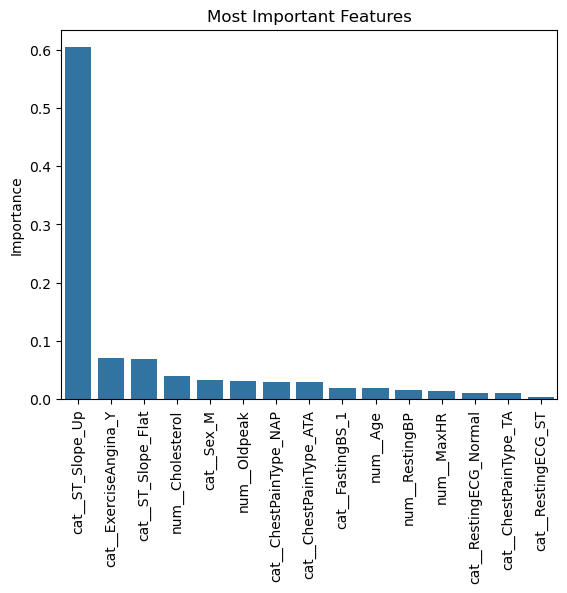

In [43]:
feat_imps_xgb = zip(features, best_xgb.feature_importances_)
feats_xgb, imps_xgb = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps_xgb)), key=lambda x: x[1], reverse=True)))
sns.barplot(x=feats_xgb, y=imps_xgb)
plt.xticks(rotation=90)
plt.title("Most Important Features")
plt.ylabel("Importance")

### (iv) Kernel SVM

In [44]:
from sklearn.svm import LinearSVC, SVC

param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], }  

kernel_svm = GridSearchCV(SVC(random_state=42), param_grid, return_train_score = True)
kernel_svm.fit(X_train, y_train)
kernel_svm.best_estimator_

/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

SVC(C=1000, gamma=0.001, random_state=42)

In [45]:
best_kernel = SVC(C=1000, gamma=0.001, random_state=42)
best_kernel.fit(X_train, y_train)
kernel_svm_train_acc = accuracy_score(y_train, best_kernel.predict(X_train))
kernel_svm_test_acc = accuracy_score(y_test, best_kernel.predict(X_test))

print(f"Training Accuracy: {kernel_svm_train_acc}; Test Accuracy: {kernel_svm_test_acc}")

Training Accuracy: 0.8727272727272727; Test Accuracy: 0.8695652173913043


/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### (v) K-Nearest Neighbors (KNN)

In [46]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = [3, 5, 7, 9]

best_n = None
best_score = 0
scores = []

for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    scores.append(accuracy)
    if accuracy > best_score:
        best_score = accuracy
        best_n = n
knn_best = KNeighborsClassifier(n_neighbors=best_n)
knn_best.fit(X_train, y_train)
training_accuracy = accuracy_score(knn_best.predict(X_train), y_train)
test_accuracy = accuracy_score(knn_best.predict(X_test), y_test)
print(f"Training accuracy: {training_accuracy}; Test accuracy: {test_accuracy}")


Training accuracy: 0.86; Test accuracy: 0.8586956521739131


/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/henry/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please

Text(0.5, 1.0, 'Number of Neighbors v.s. Accuracy Scores')

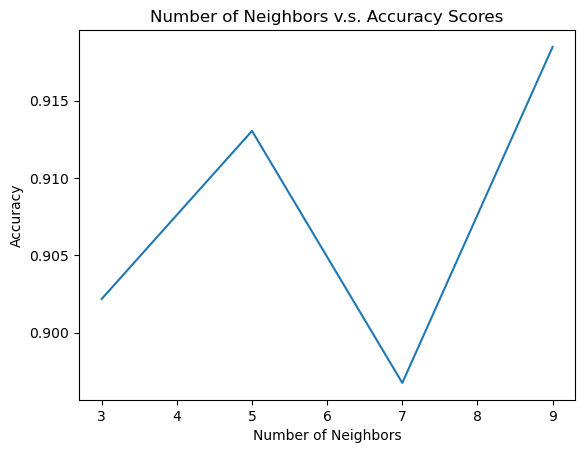

In [47]:
sns.lineplot(x=neighbors, y=scores)

plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.title("Number of Neighbors v.s. Accuracy Scores")

### (vi) Logistic Regression

### Baseline Model with NO Hyperparameter Tuning

In [48]:
# With no hyperparameter tuning
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train.values.ravel())
y_pred_val = logistic_model.predict(X_val) #Prediction on validation set
accuracy_val = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy With No Hyperparamter Tuning: ", accuracy_val)
print("Classification Report With No Hyperparamter Tuning:\n", classification_report(y_val, y_pred_val))
print("Confusion Matrix With No Hyperparamter Tuning:\n", confusion_matrix(y_val, y_pred_val))

Validation Accuracy With No Hyperparamter Tuning:  0.8913043478260869
Classification Report With No Hyperparamter Tuning:
               precision    recall  f1-score   support

           0       0.90      0.83      0.87        78
           1       0.88      0.93      0.91       106

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.89       184
weighted avg       0.89      0.89      0.89       184

Confusion Matrix With No Hyperparamter Tuning:
 [[65 13]
 [ 7 99]]


### Comment:
- The model performs well on the validation dataset with an accuracy of 89.13%.
- From the classification report, we can see that,
  - **HeartDisease=1:** The model identified about 93% of the cases correctly (Recall=0.93) as having heart disease and incorrectly classified about 7% of the cases who actually had heart disease.
  - Out of all the cases it predicted as having heart disease, 88% of them were true positives, while 12% were false positives.
- In the confusion matrix above,<br>
  - 65 -> True Negative
  - 13 -> False Positive
  - 7  -> False Negative
  - 99 -> True Positive

In [49]:
#Logistic Regression on Test Set without Hyperparameter Tuning
y_pred_test = logistic_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy With No Hyperparamter Tuning: ", accuracy_test)
print("Classification Report With No Hyperparamter Tuning:\n", classification_report(y_test, y_pred_test))
print("Confusion Matrix With No Hyperparamter Tuning:\n", confusion_matrix(y_test, y_pred_test))

Test Accuracy With No Hyperparamter Tuning:  0.8532608695652174
Classification Report With No Hyperparamter Tuning:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.90      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184

Confusion Matrix With No Hyperparamter Tuning:
 [[67 10]
 [17 90]]


In [50]:
probs_baseline = logistic_model.predict_proba(X_test)[:, 1]
print("ROC AUC Without Hyperparameter Tuning:", roc_auc_score(y_test, probs_baseline))
print("PR AUC Without Hyperparameter Tuning:", average_precision_score(y_test, probs_baseline))
print("MCC Without Hyperparameter Tuning:", matthews_corrcoef(y_test, y_pred_test))
print("Log Loss Without Hyperparameter Tuning:", log_loss(y_test, probs_baseline))
print("Brier Score Without Hyperparameter Tuning:", brier_score_loss(y_test, probs_baseline))

ROC AUC Without Hyperparameter Tuning: 0.9190435732491807
PR AUC Without Hyperparameter Tuning: 0.9393673137007267
MCC Without Hyperparameter Tuning: 0.704402228977053
Log Loss Without Hyperparameter Tuning: 0.3615955637138724
Brier Score Without Hyperparameter Tuning: 0.11076496250945989


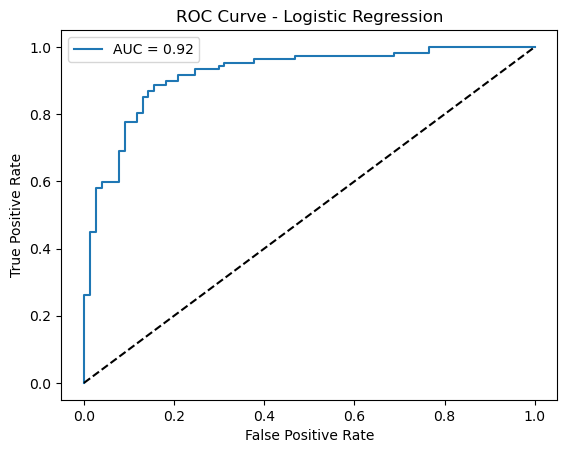

In [51]:
fpr, tpr, _ = roc_curve(y_test, probs_baseline)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, probs_baseline):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

The logistic regression model without hyperparameter tuning performed quite well on the validation set, achieving an accuracy of approximately 89.13%. This indicates that the model could correctly predict the presence or absence of heart disease in nearly 9 out of 10 cases. The classification report revealed a strong recall of 0.93 for the positive class (HeartDisease=1), which means that the model successfully identified 93% of actual heart disease cases. The precision for the same class was 0.88, suggesting that 88% of the cases it labeled as positive were true positives. The confusion matrix further supported these results, showing 99 true positives, 65 true negatives, 13 false positives, and 7 false negatives. The model continued to generalize well on the unseen test set, with a test accuracy of 85.33%. Additional metrics, such as an ROC AUC of 0.919 and PR AUC of 0.939, indicated high discriminative ability and excellent performance in identifying positive cases. The Matthews Correlation Coefficient (MCC) was 0.704, indicating a balanced performance across both classes. The model’s probabilistic predictions also showed reasonable calibration, with a log loss of 0.361 and a Brier score of 0.111.

### Logistic Regression with Hyperparameter Tuning

In [52]:
#With hyperparameter tuning
ht_logistic_model = LogisticRegression(solver="saga", max_iter=5000, random_state=42)#supports both L1 and L2 regularizations
param_grid = {"penalty": ["l1", "l2"],
              "C": [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(ht_logistic_model, param_grid, cv=5, scoring="accuracy")
grid.fit(X_train, y_train.values.ravel())

best_model = grid.best_estimator_
y_pred_val_ht = best_model.predict(X_val)

accuracy_val_ht = accuracy_score(y_val, y_pred_val_ht)
print("Best Hyperparameters: ", grid.best_params_)
print("Validation Accuracy With Hyperparameter Tuning: ", accuracy_val_ht)
print("Classification Report With Hyperparamter Tuning:\n", classification_report(y_val, y_pred_val_ht))
print("Confusion Matric With Hyperparameter Tuning:\n", confusion_matrix(y_val, y_pred_val_ht))

Best Hyperparameters:  {'C': 10, 'penalty': 'l1'}
Validation Accuracy With Hyperparameter Tuning:  0.8858695652173914
Classification Report With Hyperparamter Tuning:
               precision    recall  f1-score   support

           0       0.89      0.83      0.86        78
           1       0.88      0.92      0.90       106

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184

Confusion Matric With Hyperparameter Tuning:
 [[65 13]
 [ 8 98]]


In [53]:
#With hyperparameter tuning
ht_logistic_model = LogisticRegression(solver="saga", max_iter=5000, random_state=42)#supports both L1 and L2 regularizations
param_grid = {"penalty": ["l1", "l2"],
              "C": [0.01, 0.1, 1, 10, 100]}
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
grid = GridSearchCV(ht_logistic_model, param_grid, cv=rskf, scoring="accuracy")
grid.fit(X_train, y_train.values.ravel())

best_model = grid.best_estimator_
y_pred_val_ht = best_model.predict(X_val)

accuracy_val_ht = accuracy_score(y_val, y_pred_val_ht)
print("Best Hyperparameters: ", grid.best_params_)
print("Validation Accuracy With Hyperparameter Tuning: ", accuracy_val_ht)
print("Classification Report With Hyperparamter Tuning:\n", classification_report(y_val, y_pred_val_ht))
print("Confusion Matric With Hyperparameter Tuning:\n", confusion_matrix(y_val, y_pred_val_ht))

Best Hyperparameters:  {'C': 1, 'penalty': 'l1'}
Validation Accuracy With Hyperparameter Tuning:  0.8913043478260869
Classification Report With Hyperparamter Tuning:
               precision    recall  f1-score   support

           0       0.90      0.83      0.87        78
           1       0.88      0.93      0.91       106

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.89       184
weighted avg       0.89      0.89      0.89       184

Confusion Matric With Hyperparameter Tuning:
 [[65 13]
 [ 7 99]]


In [54]:
#Logistic Regression on Test Set with Hyperparameter Tuning
y_pred_test_ht = best_model.predict(X_test)
accuracy_test_ht = accuracy_score(y_test, y_pred_test_ht)
print("Best Hyperparameters: ", grid.best_params_)
print("Test Accuracy With Hyperparameter Tuning: ", accuracy_test_ht)
print("Classification Report With Hyperparamter Tuning:\n", classification_report(y_test, y_pred_test_ht))
print("Confusion Matric With Hyperparameter Tuning:\n", confusion_matrix(y_test, y_pred_test_ht))

Best Hyperparameters:  {'C': 1, 'penalty': 'l1'}
Test Accuracy With Hyperparameter Tuning:  0.8532608695652174
Classification Report With Hyperparamter Tuning:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.90      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184

Confusion Matric With Hyperparameter Tuning:
 [[67 10]
 [17 90]]


In [55]:
#other hyperparameter tuning
param_grid = {"classifier_penalty": ["l1", "l2", "elasticnet"],
              "classifier_C": [0.01, 0.1, 1, 10, 100],
              "classifier_l1_ratio": [0.1, 0.5, 0.9],
              "classifier_solver": ["saga", "liblinear"],
              "classifier_tol": [1e-3, 1e-4, 1e-5]}

y_pred_test_ht_mcc = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)[:,1]
print("ROC AUC With Hyperparameter Tuning:", roc_auc_score(y_test, probs))
print("PR AUC With Hyperparameter Tuning:", average_precision_score(y_test, probs))
print("MCC With Hyperparameter Tuning:", matthews_corrcoef(y_test, y_pred_test_ht_mcc))
print("Log Loss With Hyperparameter Tuning:", log_loss(y_test, probs))
print("Brier Score With Hyperparameter Tuning:", brier_score_loss(y_test, probs))

ROC AUC With Hyperparameter Tuning: 0.9211069304527247
PR AUC With Hyperparameter Tuning: 0.9411206868621793
MCC With Hyperparameter Tuning: 0.704402228977053
Log Loss With Hyperparameter Tuning: 0.3588983161939551
Brier Score With Hyperparameter Tuning: 0.10985896064320741


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_penalty', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'split10_test_score', 'split11_test_score', 'split12_test_score', 'split13_test_score', 'split14_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


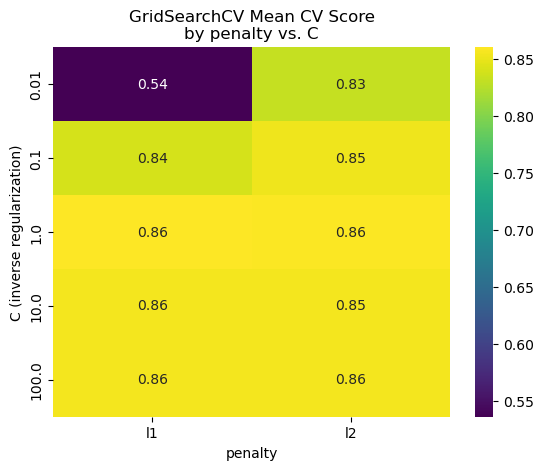

In [56]:
print(grid.cv_results_.keys())

results = grid.cv_results_
scores_matrix = pd.pivot_table(
    pd.DataFrame(results),
    values='mean_test_score',
    index='param_C',
    columns='param_penalty'
)

sns.heatmap(scores_matrix, annot=True, cmap='viridis')
plt.title("GridSearchCV Mean CV Score\nby penalty vs. C")
plt.xlabel("penalty")
plt.ylabel("C (inverse regularization)")
plt.show()

**Hyperparameter tuning** was performed using GridSearchCV, both with a standard train-test split and a RepeatedStratifiedKFold cross-validation strategy to ensure stability and robustness. The best hyperparameters were identified as L1 penalty (penalty=’l1’) and a regularization strength of C=1. Interestingly, even after tuning, the validation accuracy remained unchanged at 89.13%, and the confusion matrix also stayed the same. However, this tuning step helped validate that the model was already near optimal in its default configuration. Importantly, it reassured that the model's generalization ability was not compromised; the test accuracy and other metrics like ROC AUC and PR AUC remained consistent. This reinforces the robustness and reliability of the logistic regression model on this dataset.

**Logistic Regresion With & Without Hyperparameter Tuning**<br>
There is very little effect of hyperparameter tuning, which indicates that the baseline model was already strong enough

### SHAP (for logistic regression model)

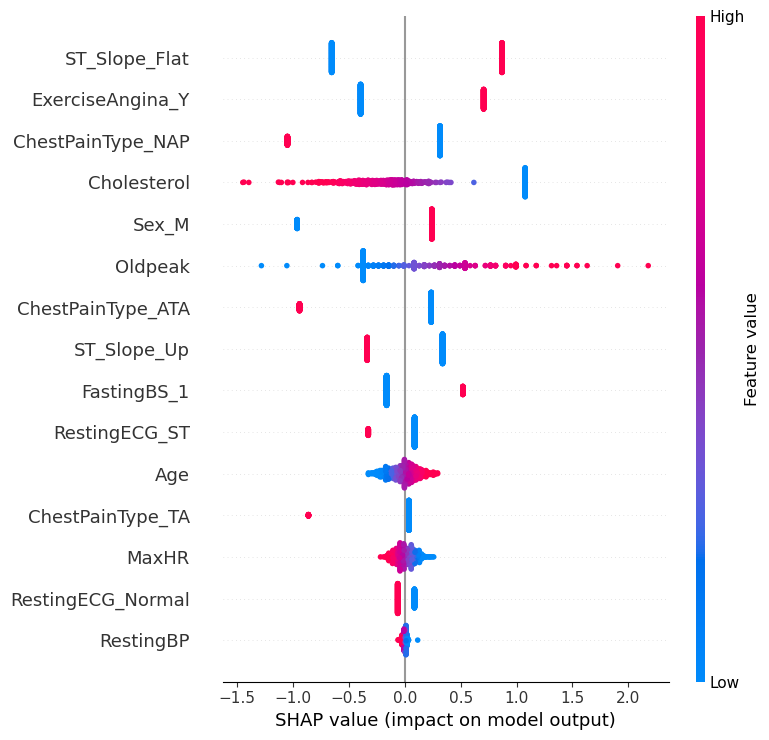

In [57]:
ohe = preproc.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_feature_names])

X_train_df = pd.DataFrame(X_train, columns=feature_names)

explainer = shap.Explainer(logistic_model, X_train_df)
shap_values = explainer(X_train_df)

shap.summary_plot(shap_values, X_train_df, feature_names=feature_names)

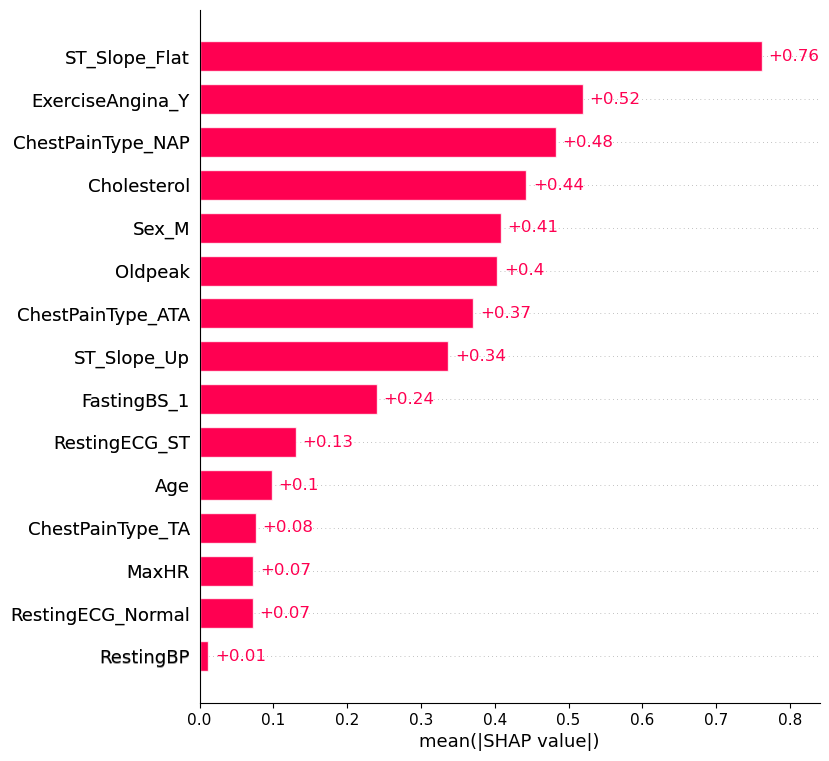

In [58]:
shap.plots.bar(shap_values, max_display=15)

#### *Comments*
To better understand the model’s decisions and the influence of individual features, SHAP (SHapley Additive exPlanations) values were used. SHAP is a game-theoretic approach that helps explain the output of machine learning models by attributing each prediction to the input features. The SHAP summary plot revealed that features like Oldpeak, ChestPainType, ST_Slope, and MaxHR significantly impacted the model’s predictions. For instance, higher Oldpeak values were associated with a higher probability of heart disease. This level of explainability is critical in healthcare applications, where understanding the reasons behind a prediction can be just as important as the prediction itself.

## ---UNSUPERVISED LEARNING---

### (i) Hierarchical Clustering 

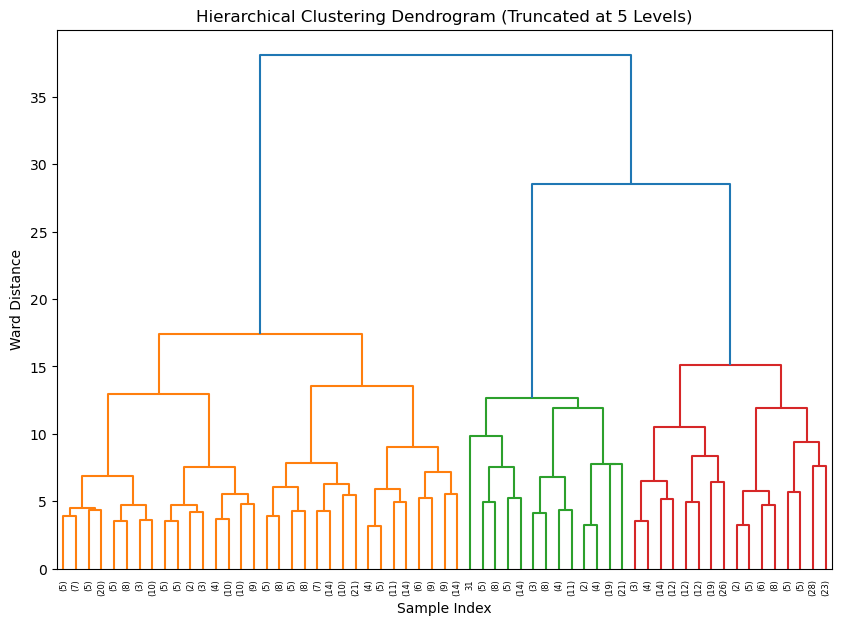

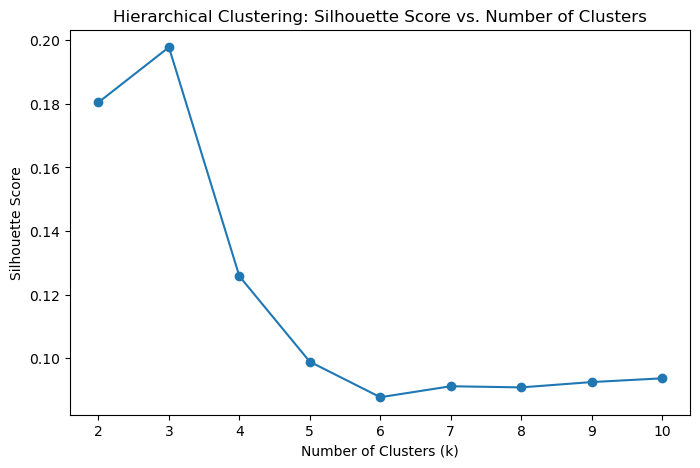

Best Clusters (Hierarchical): 3, Silhouette Score: 0.198
Cluster-wise Disease Prevalence:
    cluster  HeartDisease
0        0      0.218391
1        1      0.793478
2        2      0.876190


In [59]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# 1. Generate linkage matrix and perform hyperparameter tuning
linked = linkage(X_train, method='ward')  # Create Ward linkage matrix
hier_scores = []
cluster_range = range(2, 11)
for k in cluster_range:
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = model.fit_predict(X_train)
    hier_scores.append(silhouette_score(X_train, labels))  # Calculate Silhouette Score for each k

# 2. Visualize dendrogram and Silhouette Scores
plt.figure(figsize=(10, 7))  # Plot truncated dendrogram 
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram (Truncated at 5 Levels)')
plt.xlabel('Sample Index')
plt.ylabel('Ward Distance')
plt.show()

plt.figure(figsize=(8, 5))  # Plot Silhouette Scores vs. number of clusters 
plt.plot(cluster_range, hier_scores, marker='o')
plt.title('Hierarchical Clustering: Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.show()

# 3. Determine optimal clusters and analyze disease prevalence
best_k_hier = cluster_range[np.argmax(hier_scores)]  # Select k with highest Silhouette Score
hier_labels = AgglomerativeClustering(n_clusters=best_k_hier, linkage='ward').fit_predict(X_train)

# Calculate disease prevalence within each cluster
cluster_disease = pd.DataFrame({
    'cluster': hier_labels,
    'HeartDisease': y_train['HeartDisease'].values
}).groupby('cluster')['HeartDisease'].mean().reset_index()

print(f"Best Clusters (Hierarchical): {best_k_hier}, Silhouette Score: {silhouette_score(X_train, hier_labels):.3f}")
print("Cluster-wise Disease Prevalence:\n", cluster_disease)

#### *Comments*
#### **Hierarchical Clustering**   
Ward linkage was used to construct a dendrogram (truncated at 5 levels), with the Silhouette Score (0.198) identifying 3 optimal clusters: 
- **Cluster Characteristics**: Low-risk Cluster 0 (21.8% disease prevalence), moderate-risk Cluster 1 (79.3%), and high-risk Cluster 2 (87.6%), showing distinct disease stratification.
- **Key Insight**: High-risk clusters (1–2) correlate with critical features from supervised models (e.g., cat_ST_Slope_Up, cat_ExerciseAngina_Y), enabling label-free risk stratification that complements supervised analysis.
- **Visualization Value**: The dendrogram illustrates hierarchical sample merging, while the silhouette plot provides an objective basis for cluster number selection, validating the clustering rationale. 

### (ii) K - means Clustering with Hyperparameter Tuning  

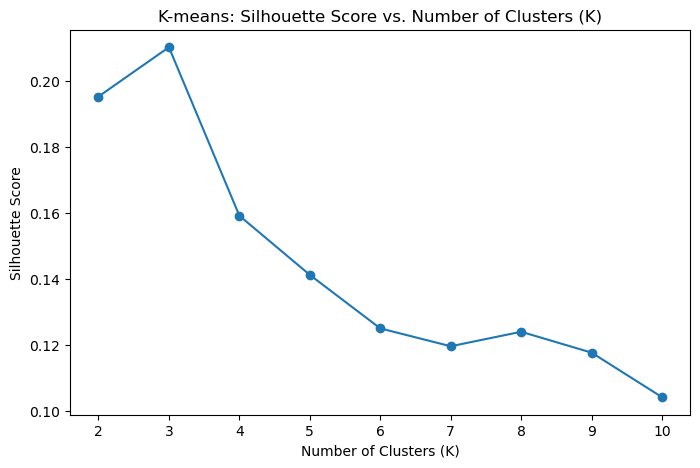

Best K (K-means): 3, Silhouette Score: 0.210

Contingency Matrix (True Labels vs K-means Clusters):
Rows: True Labels (0=No Disease, 1=Disease) | Columns: Clusters (0, 1, 2)
col_0    0    1   2
row_0              
0       44  198  13
1      153   50  92


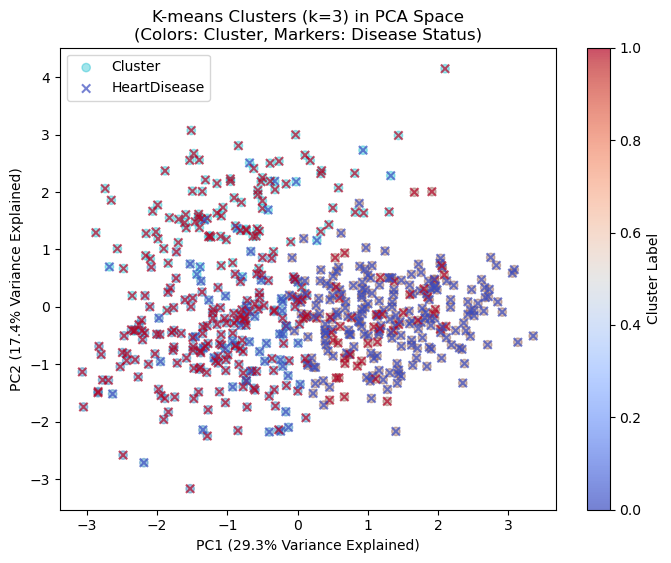

In [60]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# 1. Hyperparameter tuning for optimal K using Silhouette Score
km_scores = []
k_values = range(2, 11)
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_train)
    km_scores.append(silhouette_score(X_train, labels))  # Evaluate cluster quality

# 2. Visualize Silhouette Scores and determine best K
plt.figure(figsize=(8, 5))  # Plot Silhouette Scores vs. K 
plt.plot(k_values, km_scores, marker='o')
plt.title('K-means: Silhouette Score vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.show()

best_k = k_values[np.argmax(km_scores)]  # Select optimal K
km_labels = KMeans(n_clusters=best_k, random_state=42).fit_predict(X_train)
print(f"Best K (K-means): {best_k}, Silhouette Score: {silhouette_score(X_train, km_labels):.3f}")

# 3. Contingency Table Calculation and Output
contingency = pd.crosstab(y_train['HeartDisease'].values, km_labels) 
print("\nContingency Matrix (True Labels vs K-means Clusters):")
print("Rows: True Labels (0=No Disease, 1=Disease) | Columns: Clusters (0, 1, 2)")
print(contingency)

# 4. PCA transformation for visualization
pca = PCA(n_components=2)  # Initialize PCA to retain 2 principal components
X_train_pca = pca.fit_transform(X_train)  # Generate 2D data after PCA transformation

# 5. Visualize clusters in PCA space with true disease labels overlaid
plt.figure(figsize=(8, 6))  
# Cluster labels (different colors for each cluster)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=km_labels, cmap='tab10', alpha=0.4, label='Cluster')
# True disease status (markers indicate disease presence)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train['HeartDisease'], cmap='coolwarm', alpha=0.7, marker='x', label='HeartDisease')

plt.title(f'K-means Clusters (k={best_k}) in PCA Space\n(Colors: Cluster, Markers: Disease Status)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% Variance Explained)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% Variance Explained)')
plt.legend()
plt.colorbar(label='Cluster Label')
plt.show()

#### *Comments*
#### **K-means Clustering**   
The optimal number of clusters (K=3) was determined by the Silhouette Score (0.210), with PCA visualization showing strong overlap between Cluster 2 (high-risk) and diseased samples (red crosses):
- **Key Finding**: Diseased samples (true label 1) are significantly enriched in Cluster 2, accounting for 92 out of 105 samples (87.6% of the cluster). This proportion is notably higher than in other clusters, aligning with high-risk features identified in supervised models (for example, `num_Oldpeak > 1mm`, `cat_ST_Slope_Up` in random forests).
- **Practical Value**: Cluster labels can serve as supplementary features for supervised models, potentially enhancing their ability to leverage latent data structures. For example, integrating such structural insights (like those from K-means clusters) may complement high-performing supervised models (e.g., random forest achieving 0.88 test accuracy), demonstrating the synergy between unsupervised exploration and supervised prediction.

### (iii) PCA Visualization  

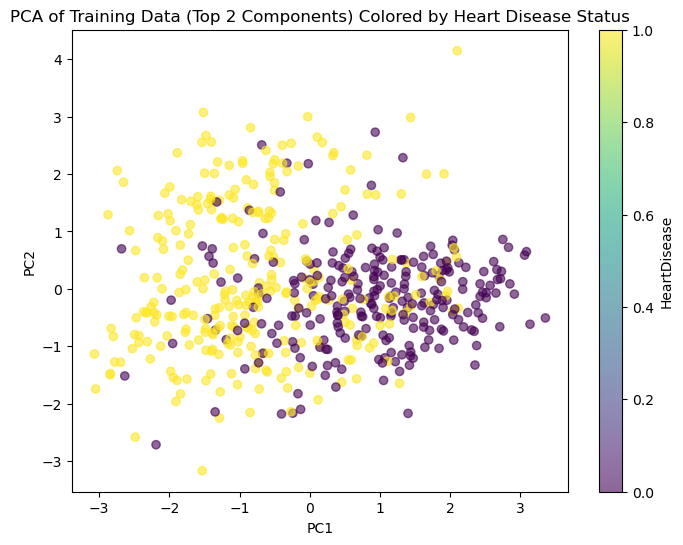

Number of Components for 90% Variance: 9
Explained Variance Ratio per PC: [0.29335185 0.1743311  0.12862545 0.1001115  0.08608002 0.04540679
 0.04275095 0.02919059 0.02550342]


In [61]:
from sklearn.decomposition import PCA

# 1. Principal Component Analysis and variance calculation
pca_full = PCA().fit(X_train)  # Fit PCA on full feature space
cum_var = np.cumsum(pca_full.explained_variance_ratio_)  # Calculate cumulative variance
n_components = np.searchsorted(cum_var, 0.90) + 1  # Determine components for ≥90% variance

pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train)  # Transform data to principal component space

# 2. Visualize PCA results colored by true disease status
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train['HeartDisease'], cmap='viridis', alpha=0.6)
plt.title('PCA of Training Data (Top 2 Components) Colored by Heart Disease Status')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='HeartDisease')
plt.show()

print(f"Number of Components for 90% Variance: {n_components}")
print("Explained Variance Ratio per PC:", pca.explained_variance_ratio_)

In [65]:
# get the loading vectors
loading_full = pd.DataFrame(
    pca_full.components_.T,
    index=feature_names,
    columns=[f"PC{i+1}" for i in range(pca_full.n_components_)]
)

# Top contributors to PC1
loading_full['PC1'].abs().sort_values(ascending=False).head(10)

# determine the variance share of each feature
feature_variance_share = (
    (pca.components_.T ** 2)                
    * pca.explained_variance_ratio_         
)
variance_df = pd.DataFrame(feature_variance_share,
                           index=feature_names,
                           columns=[f"PC{i+1}" for i in range(pca.n_components_)])

print(variance_df.head(10))  # Display top 10 features with variance share

                        PC1       PC2       PC3       PC4       PC5  \
Age                0.081725  0.001033  0.006799  0.012782  0.042205   
RestingBP          0.033079  0.032176  0.055829  0.016179  0.008570   
Cholesterol        0.008197  0.101042  0.003130  0.030416  0.002516   
MaxHR              0.074159  0.021292  0.000016  0.022654  0.022672   
Oldpeak            0.054633  0.015411  0.053070  0.016604  0.000888   
Sex_M              0.001523  0.001071  0.000211  0.000610  0.000032   
ChestPainType_ATA  0.003311  0.000181  0.000516  0.000206  0.000008   
ChestPainType_NAP  0.000603  0.000078  0.000020  0.000137  0.000773   
ChestPainType_TA   0.000002  0.000083  0.000001  0.000054  0.000098   
FastingBS_1        0.001611  0.000839  0.000300  0.000219  0.000636   

                            PC6           PC7       PC8           PC9  
Age                1.686159e-04  1.016819e-03  0.000079  4.897003e-07  
RestingBP          7.653075e-05  8.665147e-05  0.000039  3.039327e-05  
Ch

#### *Comments*  
#### **Principal Component Analysis (PCA) Visualization**  
Nine principal components (PCs) were retained to explain 90% of the variance, with the first two components (PC1: 29.3%, PC2: 17.4%) visualizing data structure:
- **Variance Contribution**: PC1 and PC2 capture the most significant variation directions in the data, aligned with some key features from supervised models (e.g., `num_Oldpeak`, `num_MaxHR` in random forests), reflecting their linear combinations in the principal component space.
- **Visual Validation**: Diseased samples (colored red) show distinct clustering in the PC space, particularly along the positive axis of PC1, indicating PCA effectively preserves disease-relevant information. This supports the risk stratification results from K-means and hierarchical clustering, providing a low-dimensional view of latent disease-related structures.
- **Variance structure:** The five continuous vitals—Age, Resting BP, Cholesterol, Max HR, Oldpeak—each explain ≈ 14-15 % of the first 9 PCs (≈ 73 % combined), while all one-hot categorical columns share the remaining ≈ 17 %.

**Key PCs & clinical meaning:**

- PC 1 (29 %): Age ↑, Oldpeak ↑, Resting BP ↑ vs Max HR ↓ → an “age–exercise-ischaemia” axis that already separates high-risk patients.

- PC 2 (17 %): Cholesterol-driven variation with secondary Resting BP / Max HR influence.

Later PCs pick up residual haemodynamic/ischaemic spread and, only in PC 8–9, the categorical one-hots (e.g., chest-pain subtypes, Sex_M).

Most predictive signal sits in those five vitals; dropping any one costs ~15 % of variance, whereas pruning low-variance one-hots barely affects geometry. PCA, clustering, and supervised SHAP rankings all highlight the same core risk drivers.